$$
\newcommand{\paren}[1]{\left(#1\right)}
\newcommand{\brac}[1]{\left\{#1\right\}}
\newcommand{\brak}[1]{\left[#1\right]}
\newcommand{\abs}[1]{\left|#1\right|}
\newcommand{\E}[1]{\mathbb{E}\left[#1\right]}
\newcommand{\pr}[1]{\Pr\paren{#1}}
\newcommand{\hpr}[1]{\widehat{\Pr}\paren{#1}}
\newcommand{\hgamma}[0]{\hat{\gamma}}
\newcommand{\hmu}[0]{\hat{\mu}}
\newcommand{\hnu}[0]{\hat{\nu}}
\newcommand{\halpha}[0]{\hat{\alpha}}
\newcommand{\ua}[0]{\underline{a}}
$$

# 3章 認知形成を数理モデリングする


## ステップ1： ビジネス課題を数理最適化問題として定式化する

## ステップ2：数理モデル構築し、未知のパラメータをデータから推定する

In [1]:
import json  # ファイル読み込み
from typing import Self  # 型ヒント

import matplotlib.pyplot as plt  # 可視化
import numpy as np  # データ処理
import polars as pl  # データ処理
import seaborn as sns  # 可視化
from matplotlib.axes import Axes  # 型ヒント
from matplotlib.figure import Figure  # 型ヒント
from matplotlib.ticker import PercentFormatter  # 型ヒント

In [2]:
# 乱数を固定
np.random.seed(42)

# データの表示設定
pl.Config.set_float_precision(precision=3)

# 可視化の設定
with open("../setting/visualization.json") as f:
    setting = json.load(f)
sns.set_theme(**setting)
sns.set_palette("gray", 4)

In [3]:
# データの読み込み

# 100時点のデータ
df_awareness = pl.read_csv("../data/ch03/awareness.csv")

# 2時点のデータ
df_awareness_observed = pl.read_csv("../data/ch03/awareness_observed.csv")

# 観測できない100時点のデータの確認
df_awareness

t,g,r,a,n_awareness,n_total
i64,f64,f64,f64,i64,i64
1,0.032,0.032,0.487,975,2000
22,0.124,0.102,0.480,961,2000
37,0.211,0.146,0.510,1020,2000
62,0.314,0.189,0.524,1049,2000
75,0.407,0.224,0.545,1090,2000
…,…,…,…,…,…
1644,8.968,0.755,0.705,1409,2000
1662,9.075,0.756,0.719,1438,2000
1682,9.174,0.759,0.734,1468,2000


In [4]:
# 観測できた2時点のみのデータを確認
df_awareness_observed

t,g,r,a,n_awareness,n_total
i64,f64,f64,f64,i64,i64
1,0.032,0.032,0.487,975,2000
1708,9.364,0.764,0.717,1434,2000


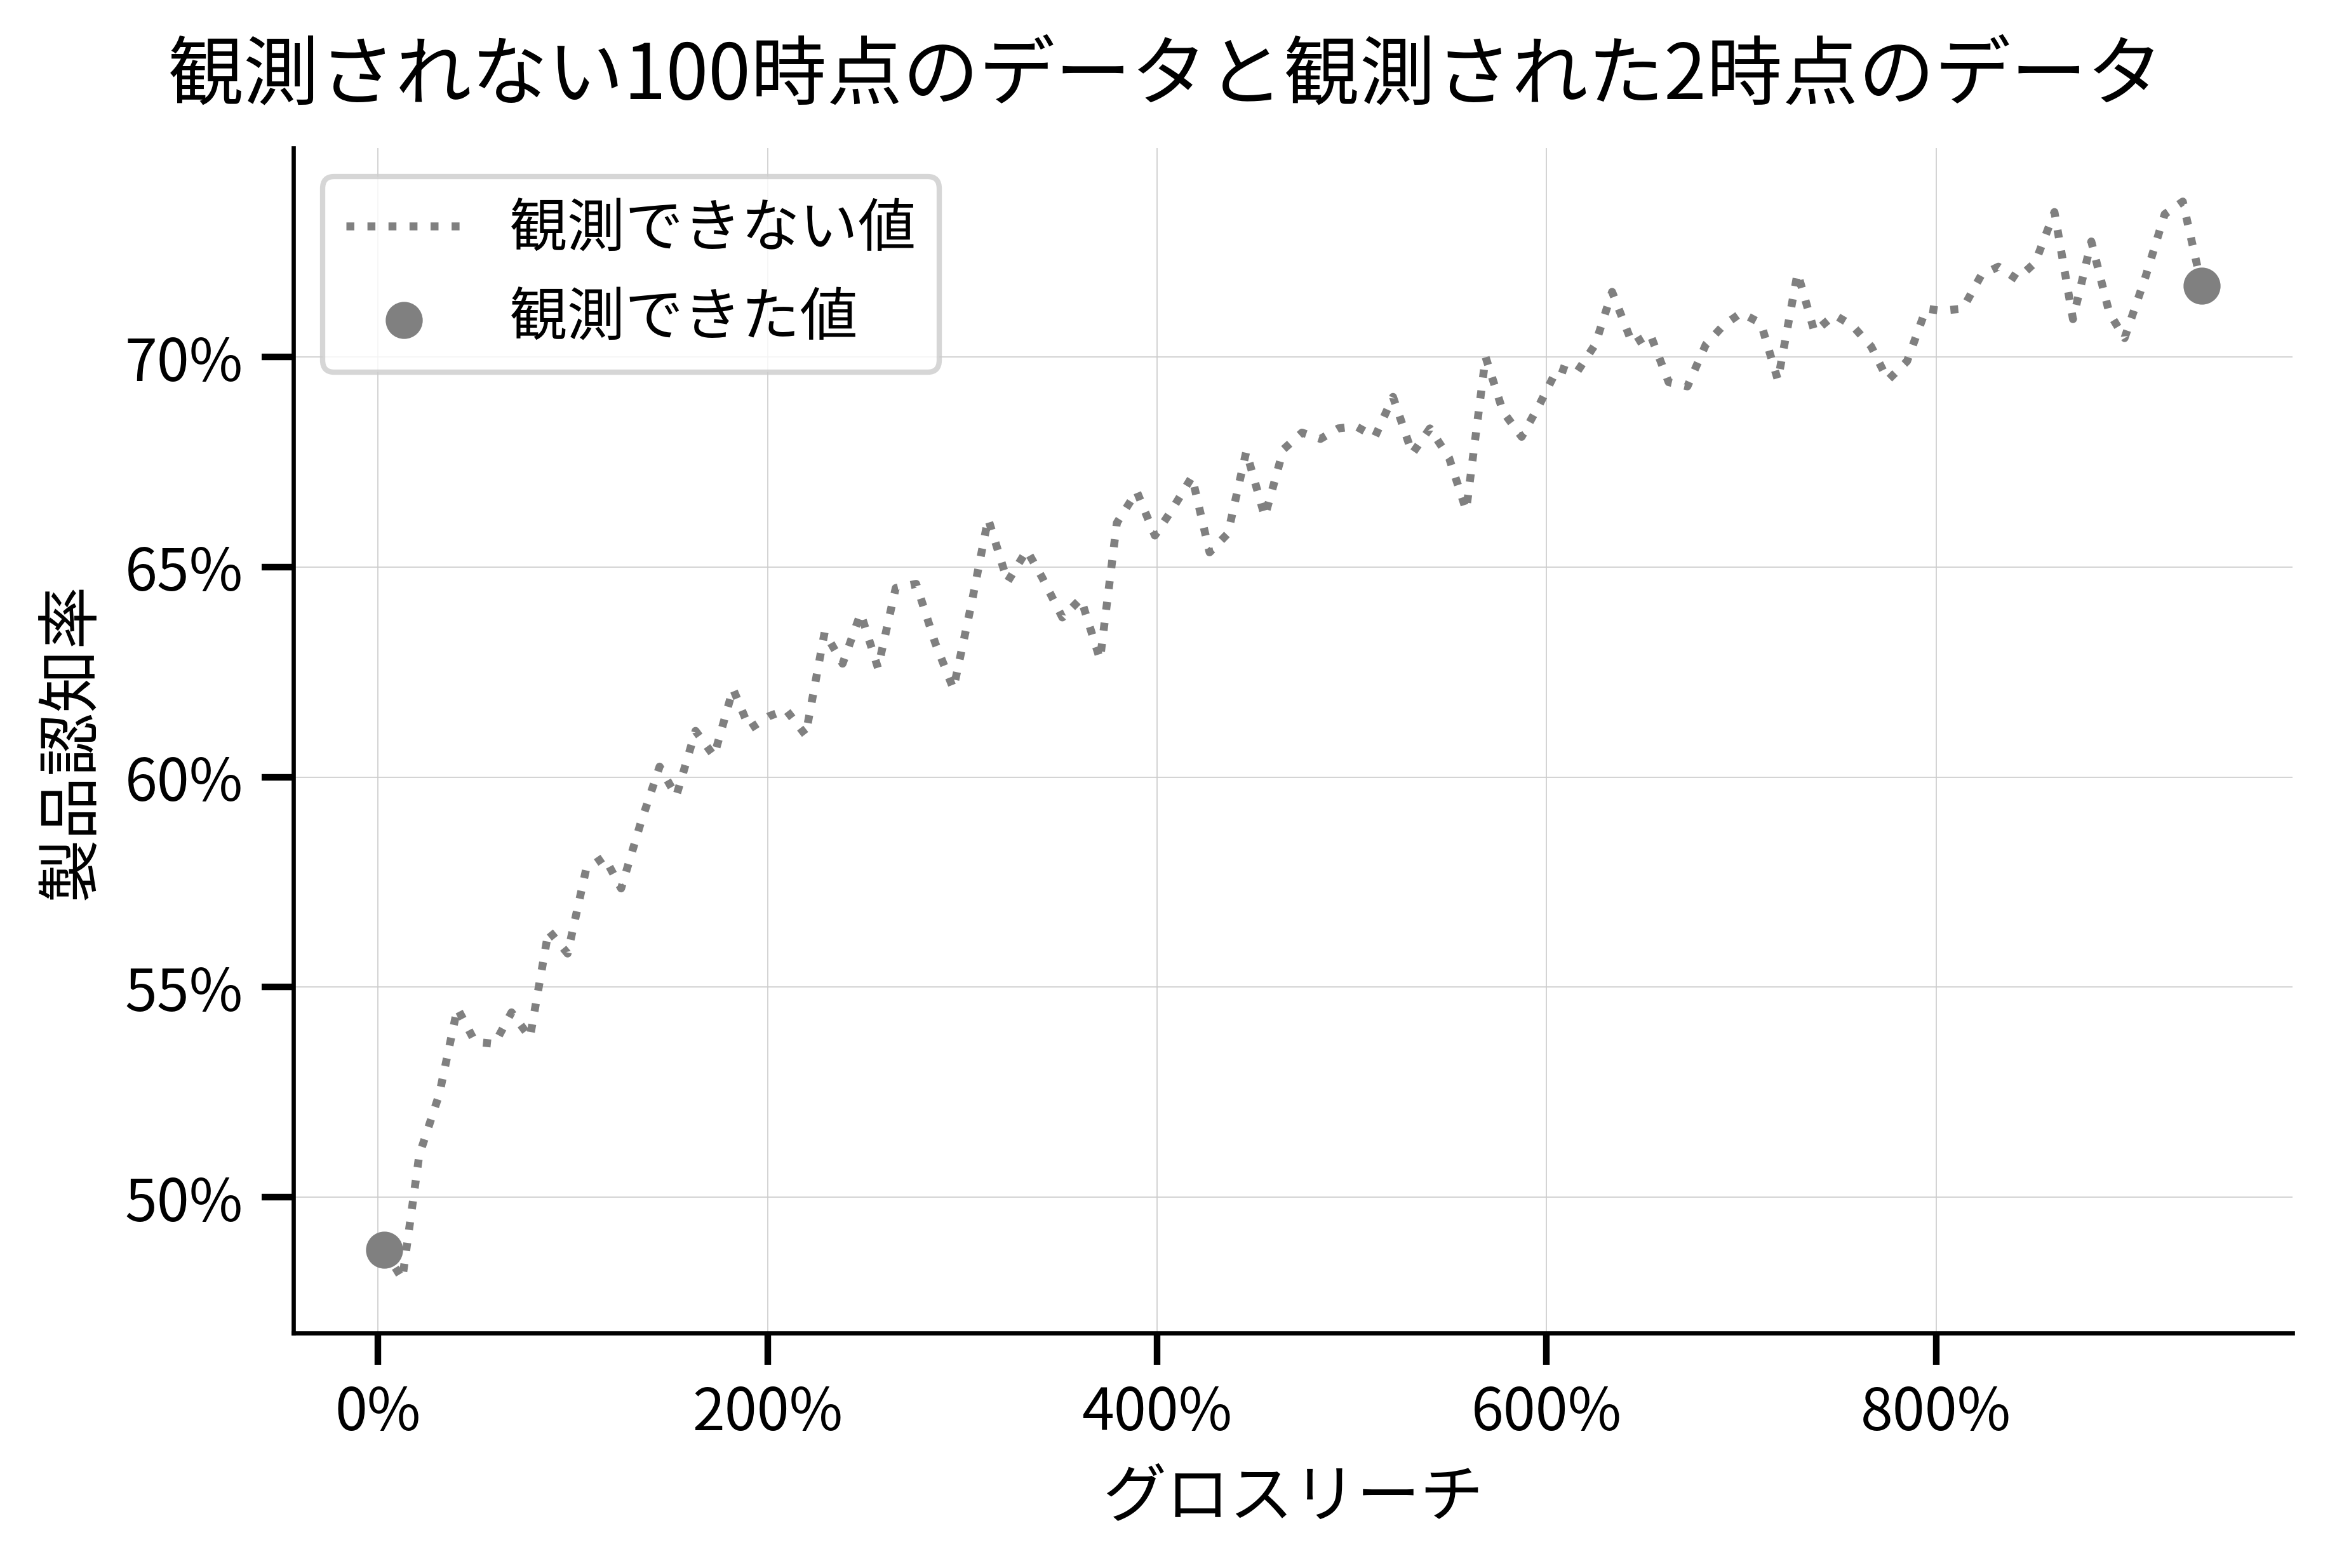

In [5]:
def plot_awareness(
    df_awareness: pl.DataFrame,
    df_awareness_observed: pl.DataFrame,
    title: str,
) -> tuple[Figure, Axes]:
    fig, ax = plt.subplots()

    ax.plot(
        df_awareness["g"],
        df_awareness["a"],
        linestyle="dotted",
        c=".5",
        label="観測できない値",
        zorder=1,
    )
    ax.scatter(
        df_awareness_observed["g"],
        df_awareness_observed["a"],
        c=".5",
        label="観測できた値",
        zorder=2,
    )
    ax.legend()
    ax.xaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
    ax.set(xlabel="グロスリーチ", ylabel="製品認知率")
    fig.suptitle(title)

    return fig, ax


fig, ax = plot_awareness(
    df_awareness=df_awareness,
    df_awareness_observed=df_awareness_observed,
    title="観測されない100時点のデータと観測された2時点のデータ",
)

In [6]:
# 学習用データ。2点のみ
g_train = df_awareness_observed[["g"]].to_numpy()  # scikit-learnの入力形式に合わせる
r_train = df_awareness_observed["r"].to_numpy()
a_train = df_awareness_observed["a"].to_numpy()

# テスト用データ。観測されていないデータも含む全時点データ
g_test = df_awareness[["g"]].to_numpy()

In [7]:
from sklearn.ensemble import RandomForestRegressor

# Random Forestによる認知カーブの推定
rf = RandomForestRegressor(n_jobs=-1, random_state=42)
rf.fit(g_train, a_train)
a_pred_rf = rf.predict(g_test)

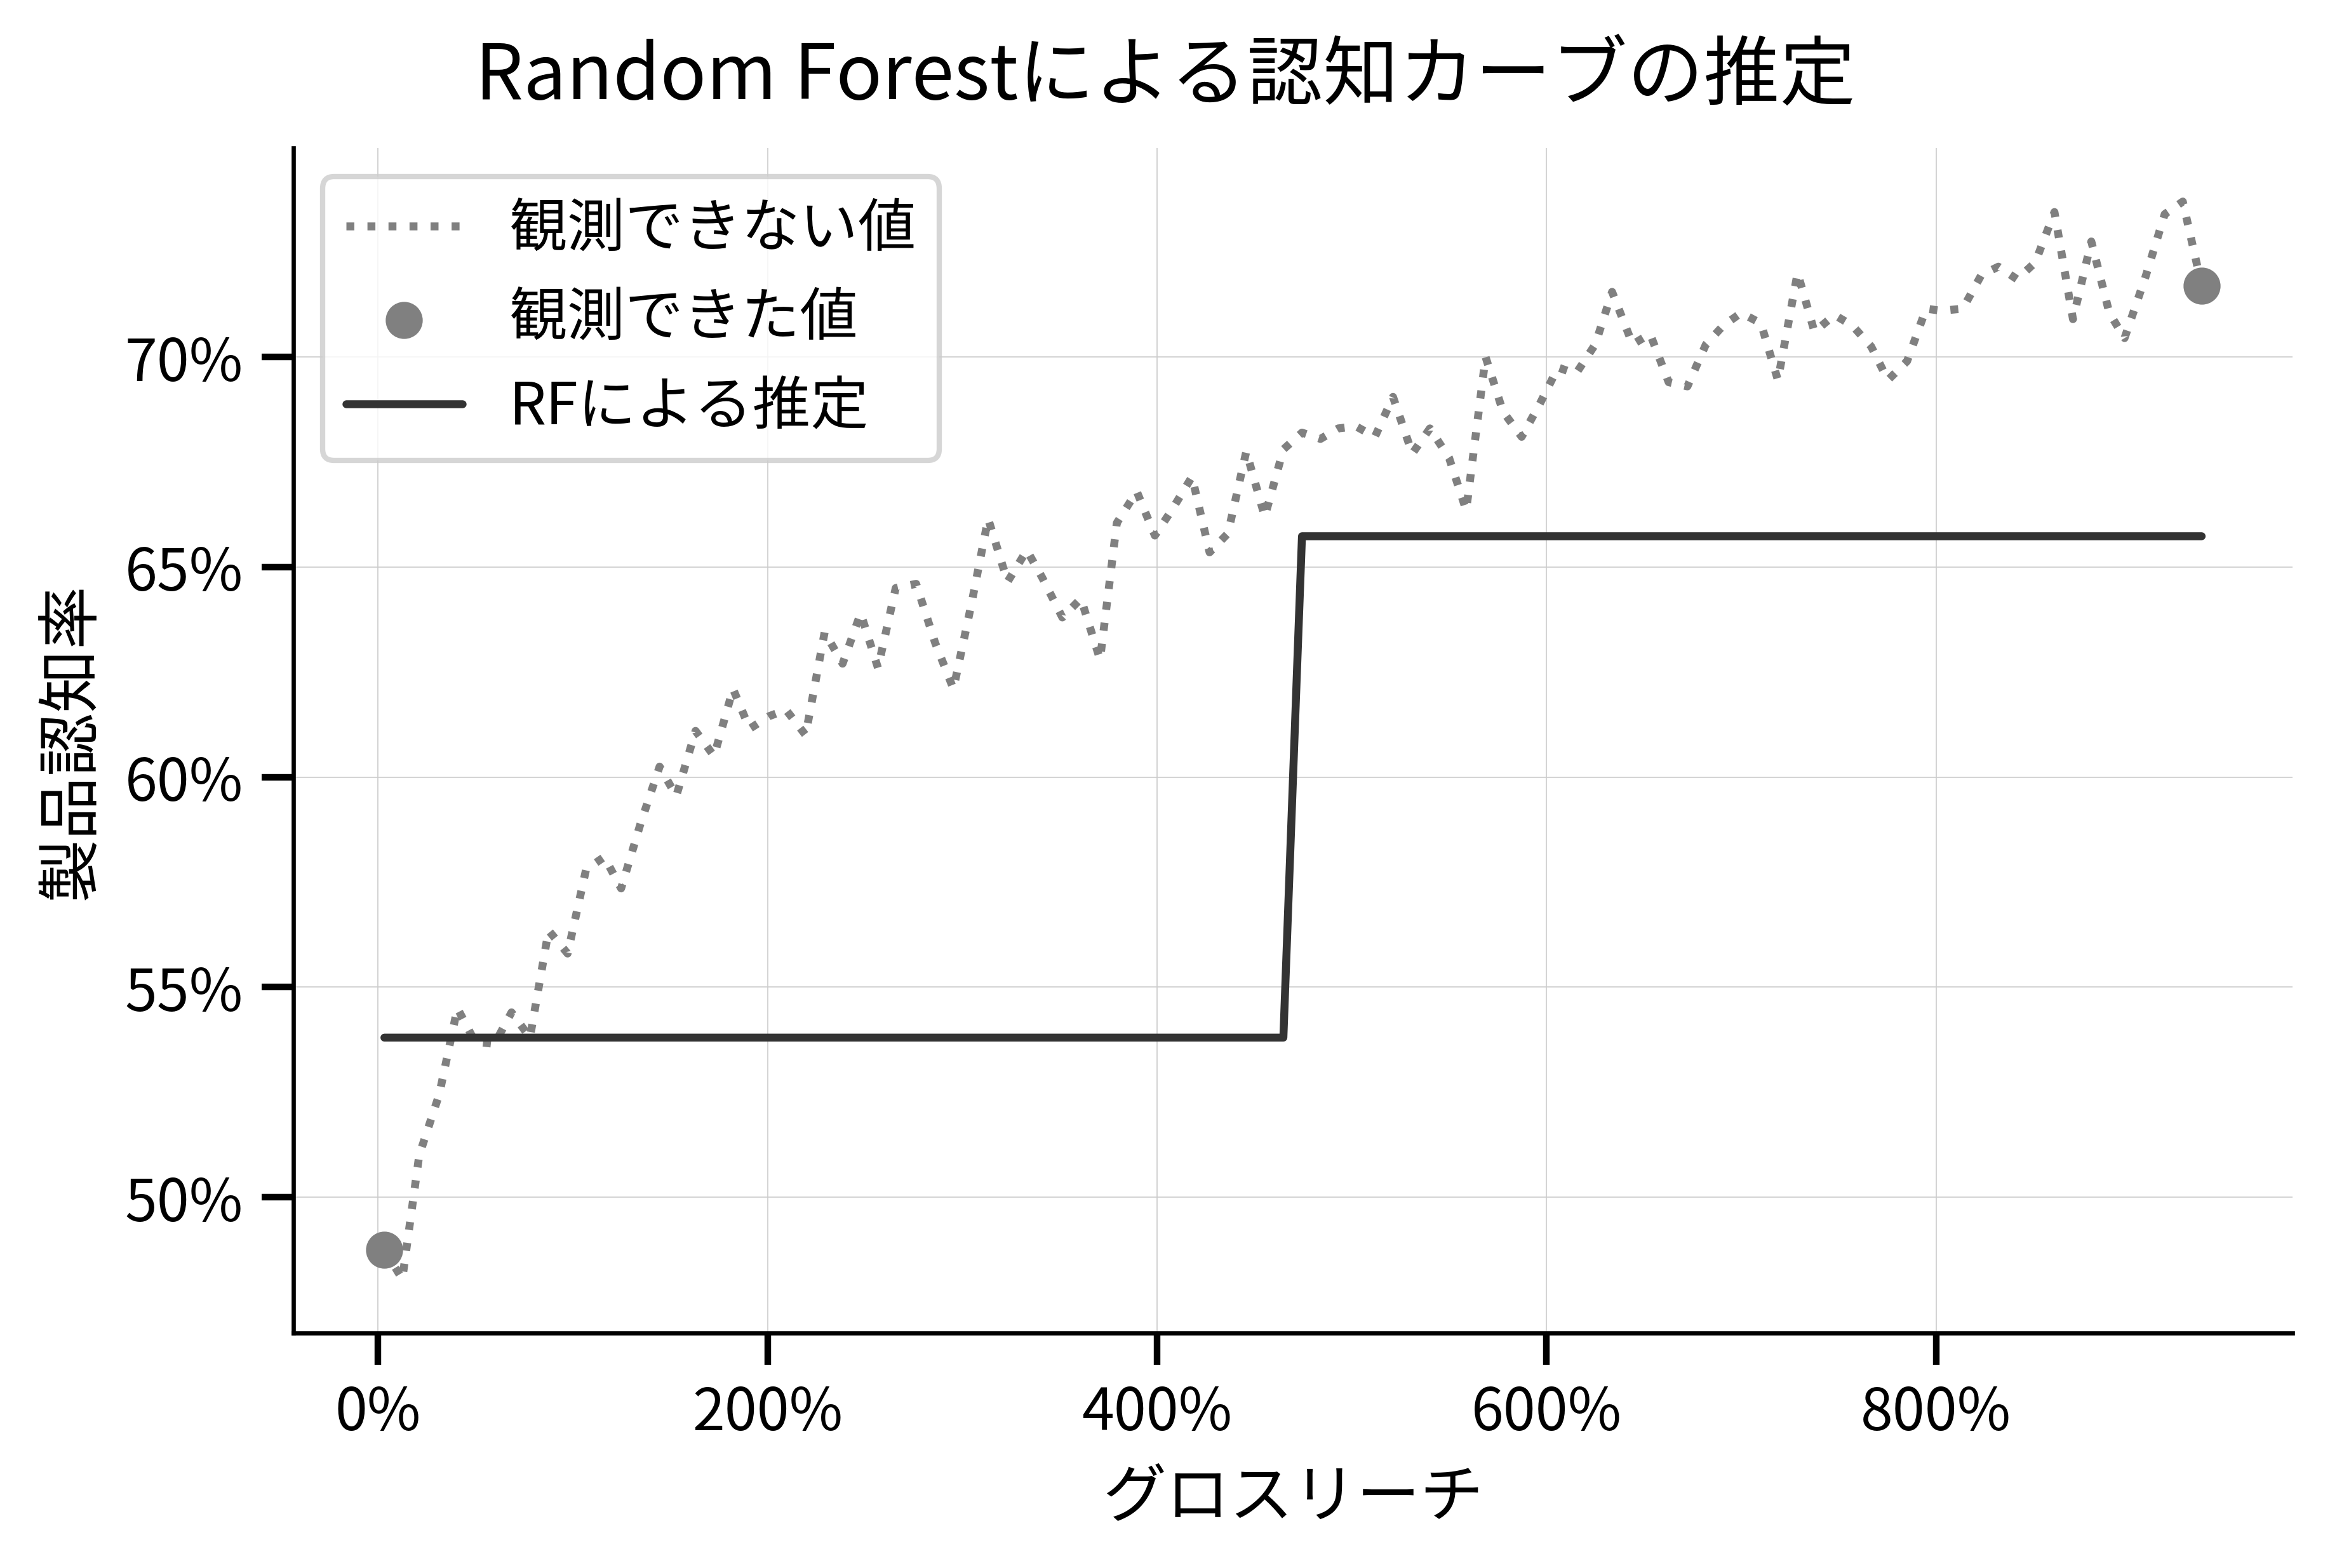

In [8]:
def plot_awareness_with_prediction(
    df_awareness: pl.DataFrame,
    df_awareness_observed: pl.DataFrame,
    a_pred: np.ndarray,
    prediction_label: str,
    title: str,
) -> tuple[Figure, Axes]:
    """実測値に合わせてモデルによる予測値を可視化"""

    fig, ax = plot_awareness(
        df_awareness=df_awareness,
        df_awareness_observed=df_awareness_observed,
        title=title,
    )
    ax.plot(df_awareness["g"], a_pred, label=prediction_label)
    ax.legend()

    return fig, ax


# 可視化
fig, ax = plot_awareness_with_prediction(
    df_awareness=df_awareness,
    df_awareness_observed=df_awareness_observed,
    a_pred=a_pred_rf,
    prediction_label="RFによる推定",
    title="Random Forestによる認知カーブの推定",
)

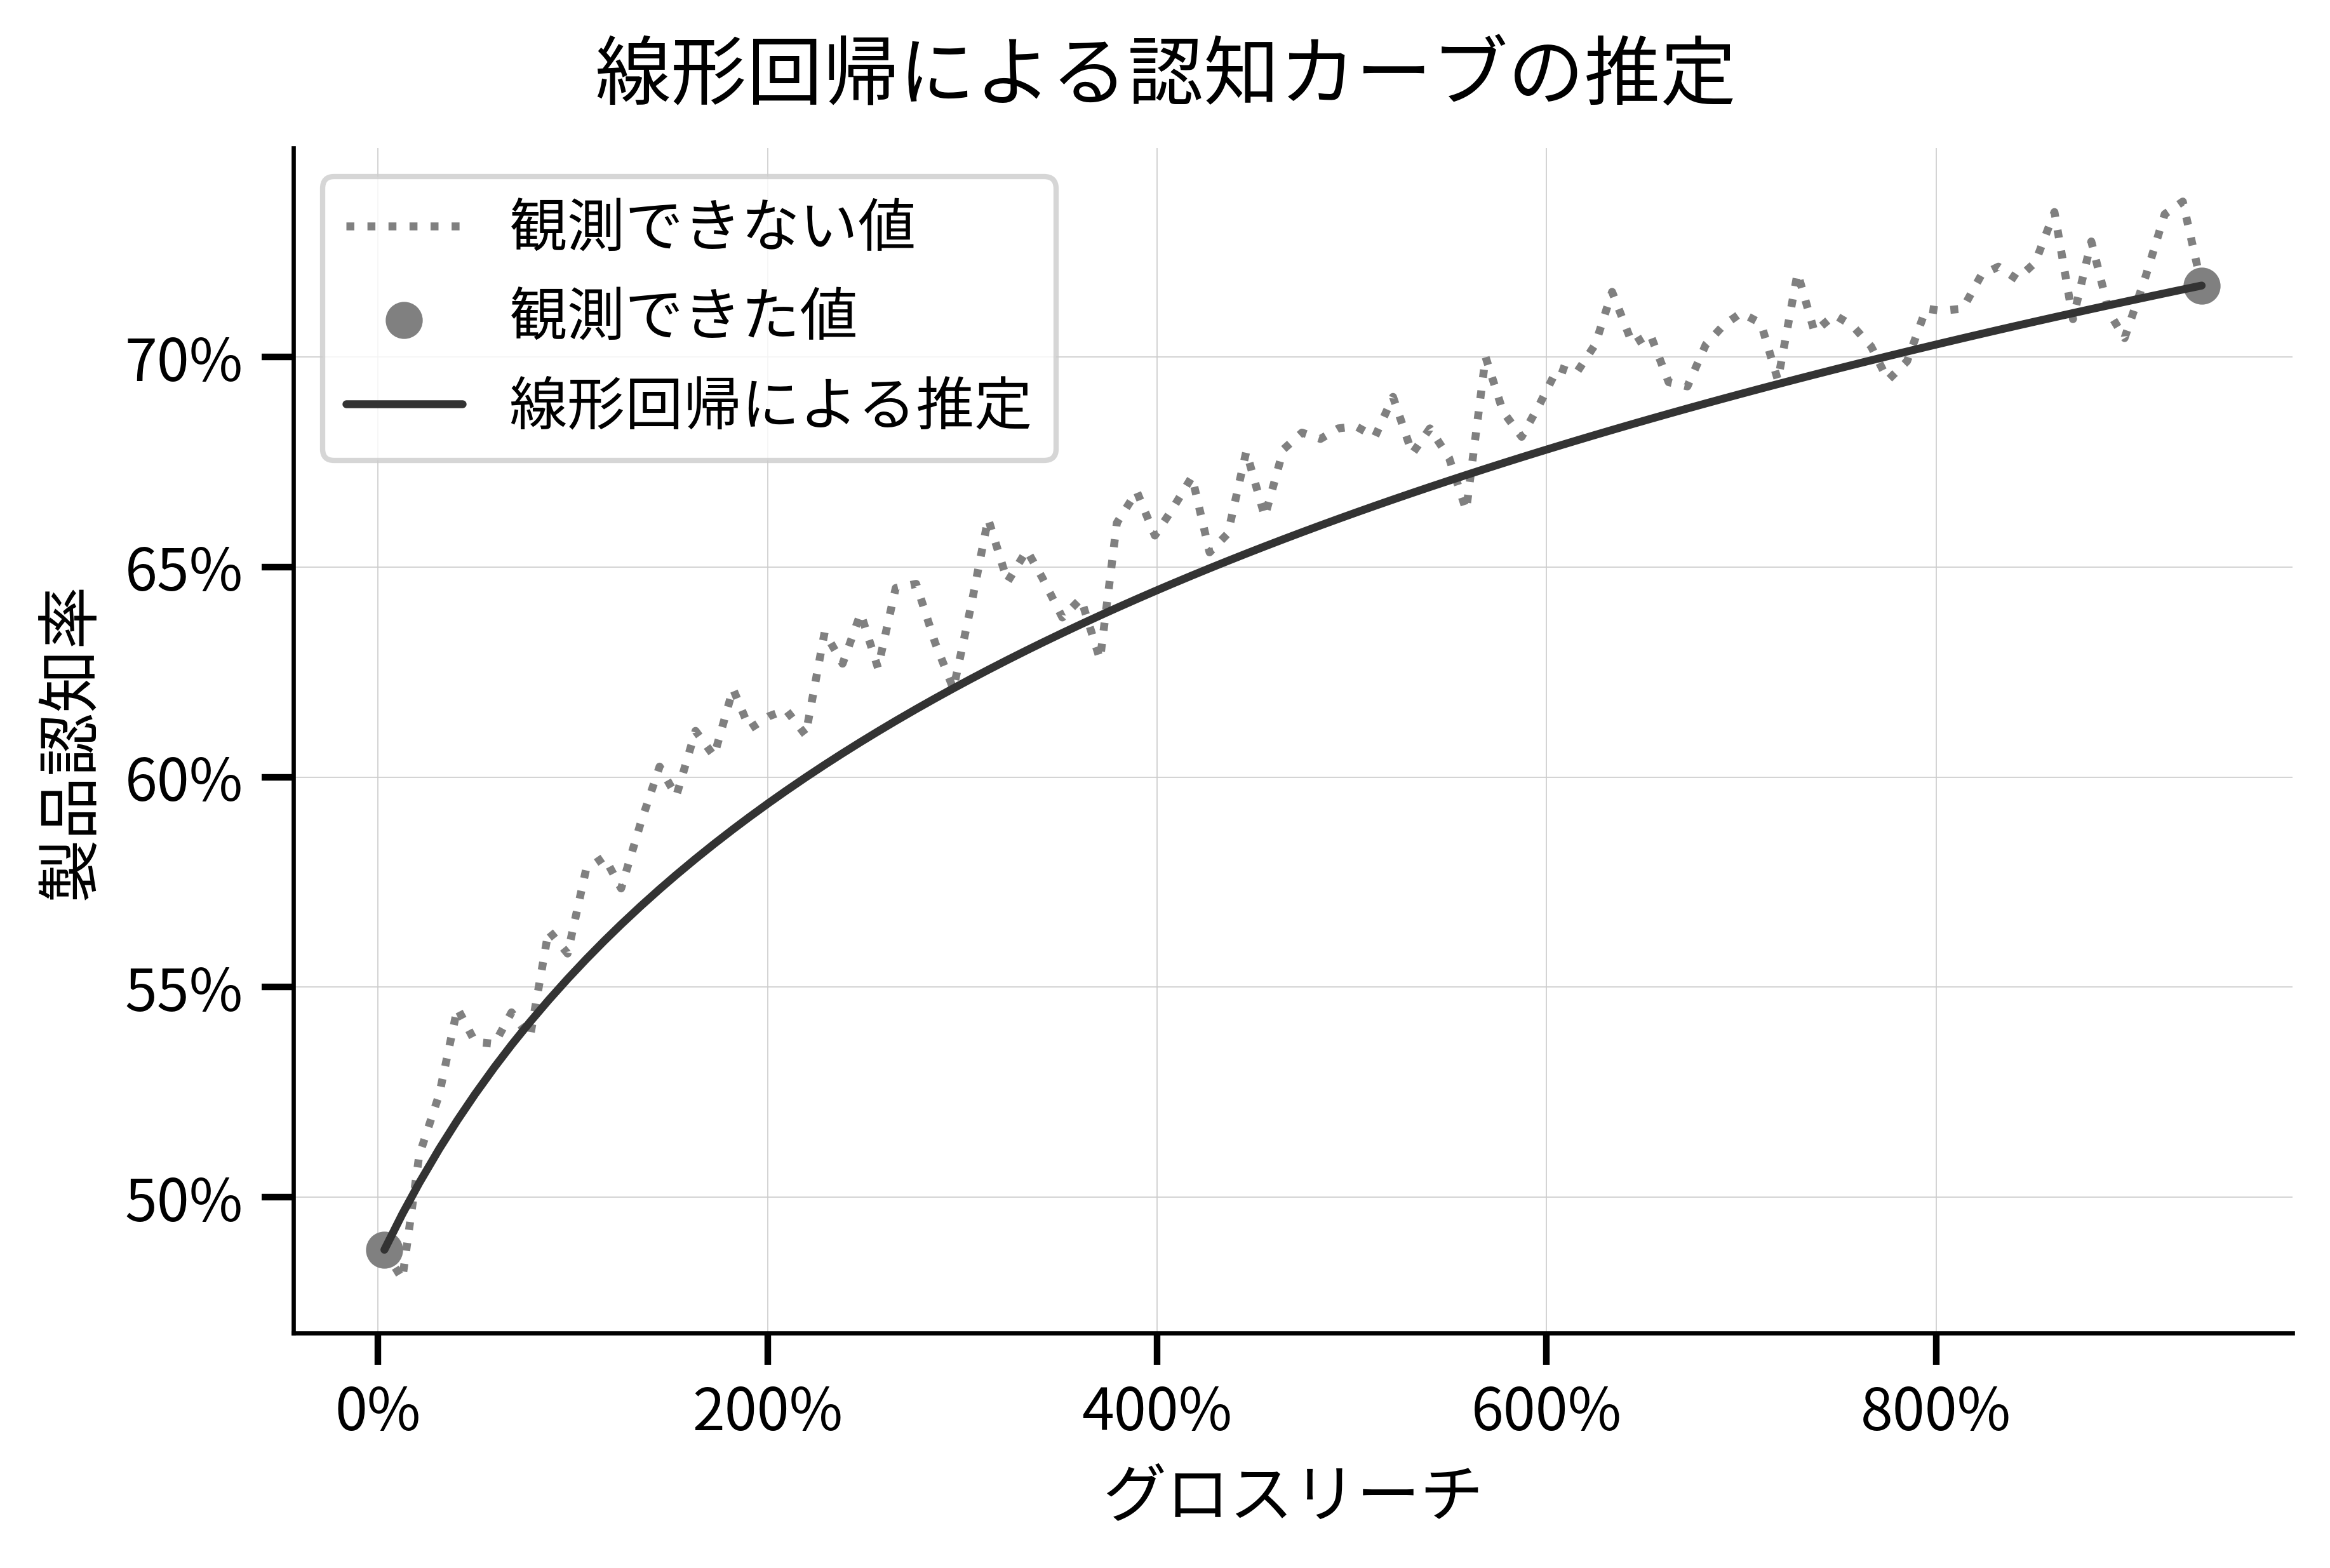

In [9]:
from sklearn.linear_model import LinearRegression

# 対数変換した場合の認知カーブの推定
lr = LinearRegression()
lr.fit(np.log1p(g_train), a_train)  # log1p(x) = log(x + 1)
a_pred_lr = lr.predict(np.log1p(g_test))  # 認知カーブの推定

# 可視化
fig, ax = plot_awareness_with_prediction(
    df_awareness=df_awareness,
    df_awareness_observed=df_awareness_observed,
    a_pred=a_pred_lr,
    prediction_label="線形回帰による推定",
    title="線形回帰による認知カーブの推定",
)

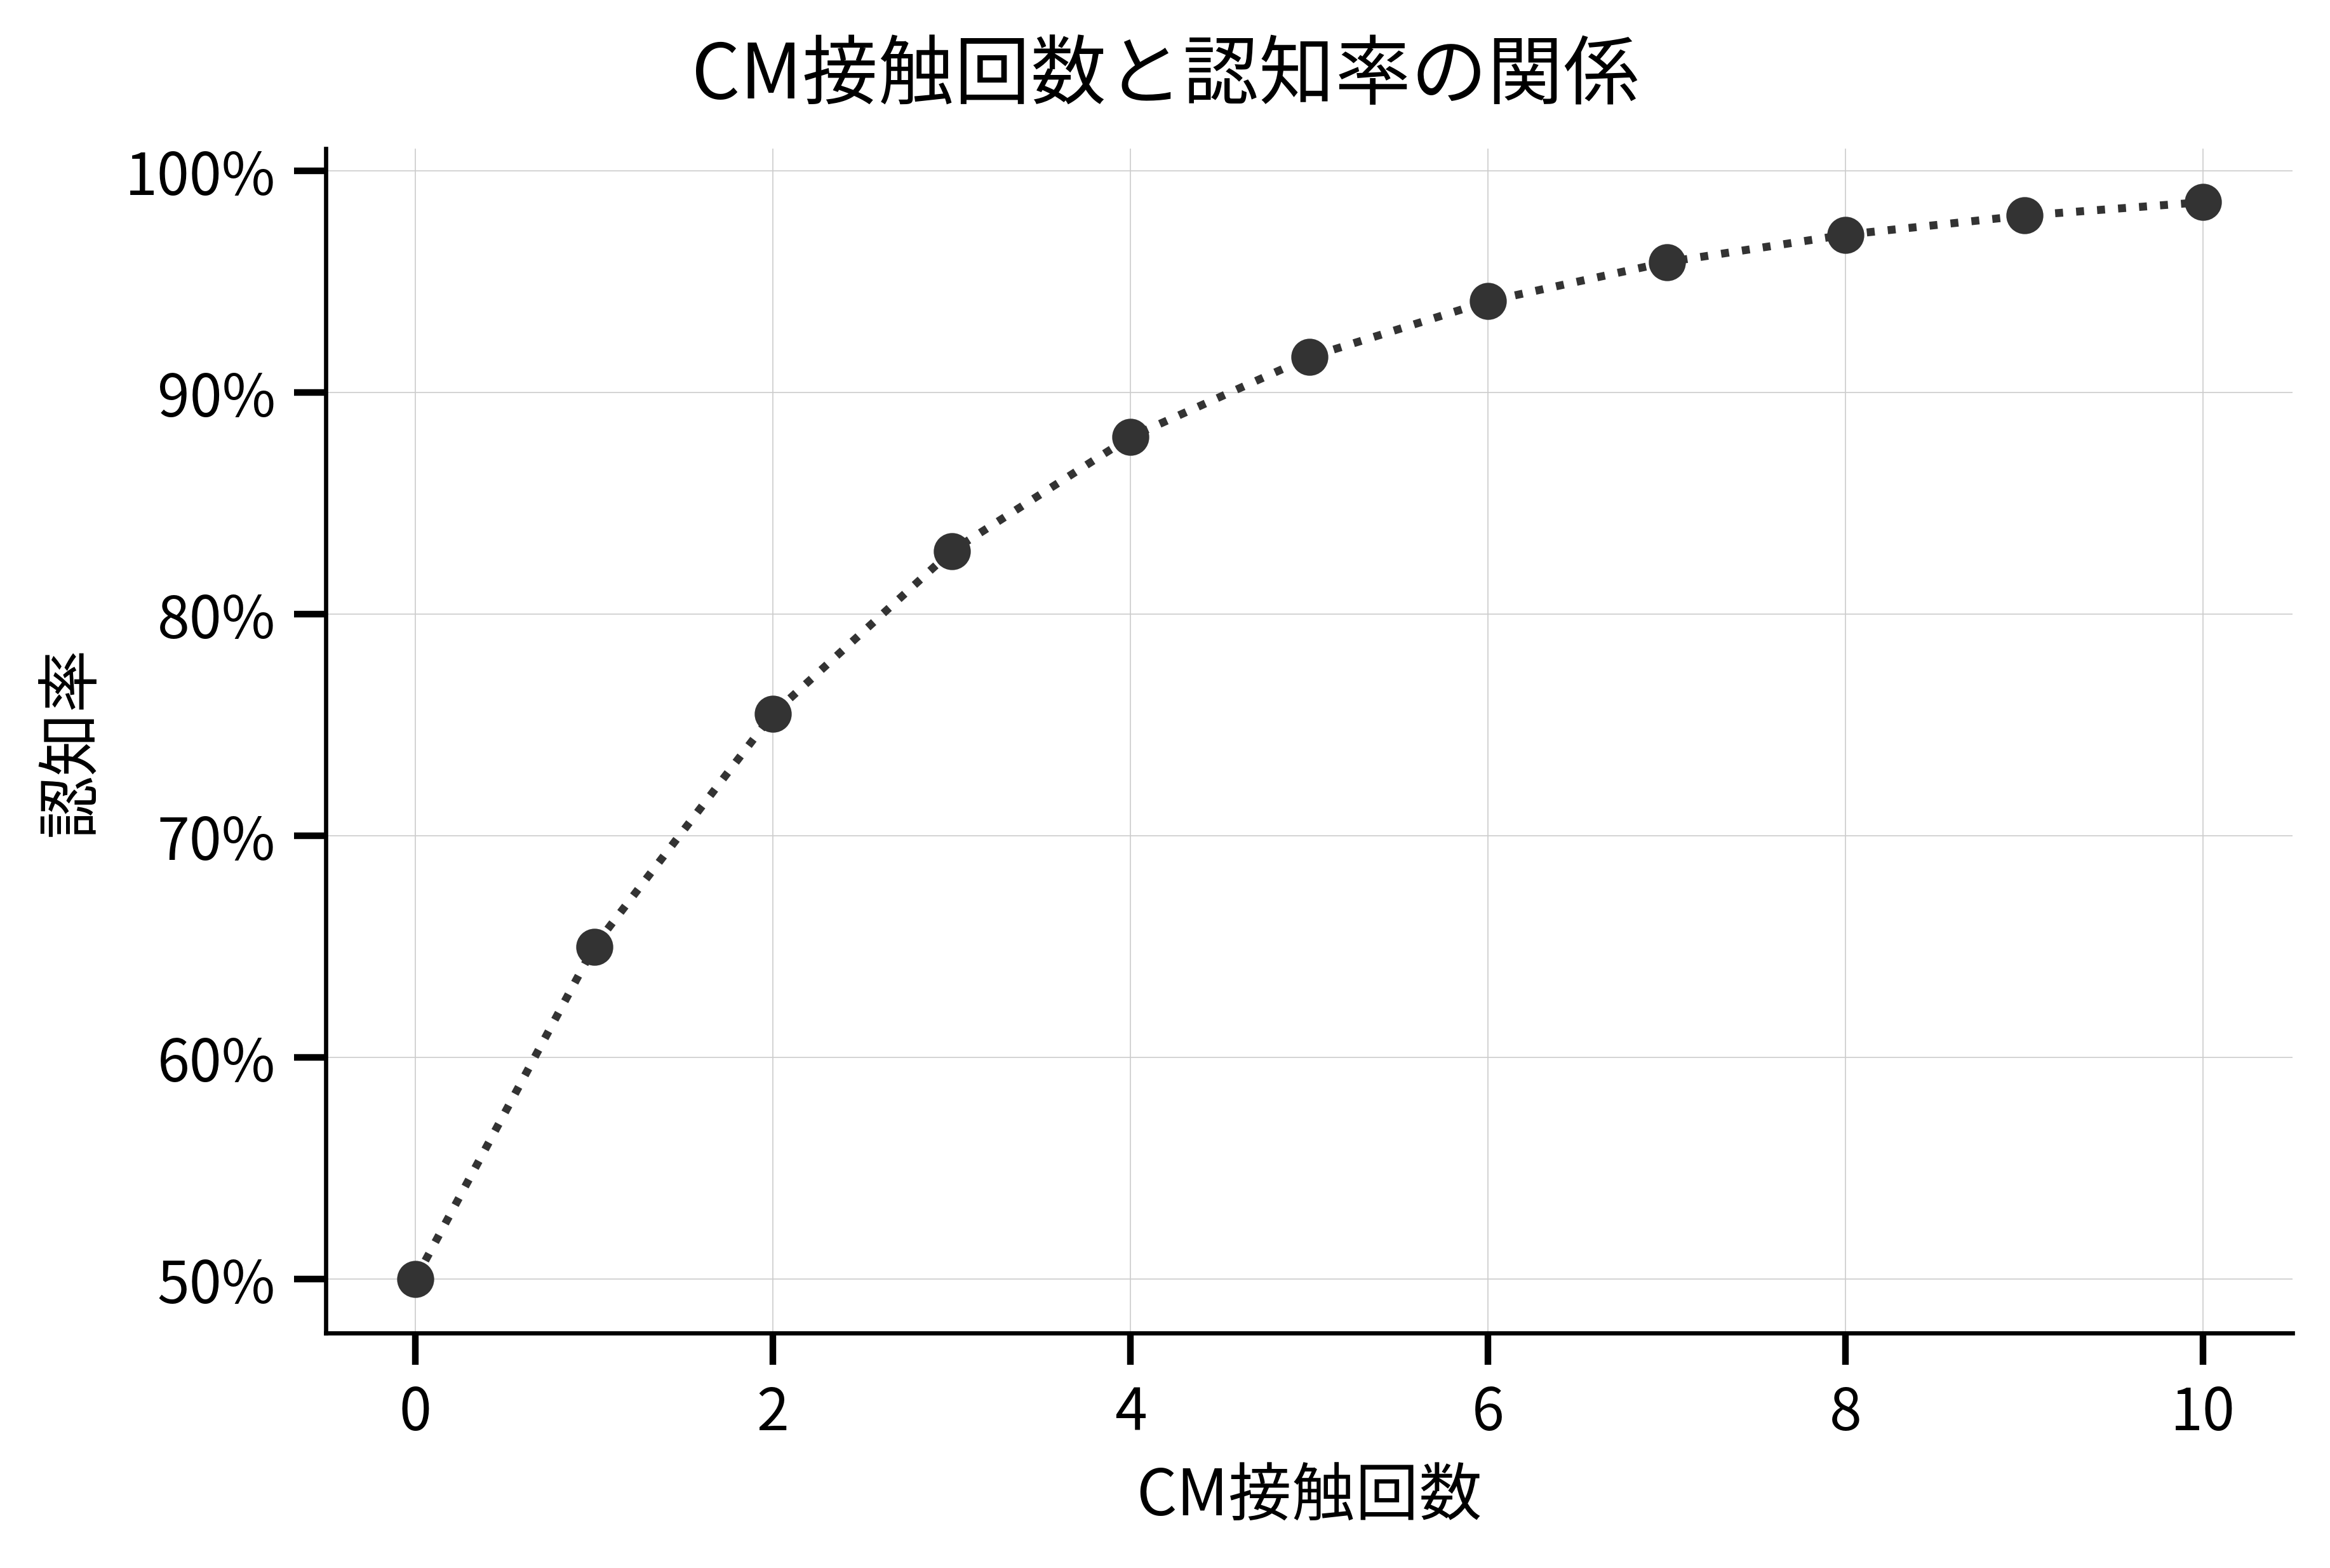

In [10]:
def plot_awareness_frequency_relation(
    f: np.ndarray, a_pred: np.ndarray
) -> tuple[Figure, Axes]:
    fig, ax = plt.subplots()

    ax.plot(f, a_pred, linestyle="dotted", zorder=1)
    ax.scatter(f, a_pred, zorder=2)

    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
    ax.set(xlabel="CM接触回数", ylabel="認知率")
    fig.suptitle("CM接触回数と認知率の関係")

    return fig, ax


# パラメータの設定
f = np.arange(0, 11)  # CM接触回数
gamma = 0.5  # 製品をそもそも知っている割合
theta = 0.3  # 製品認知率
a_pred = 1 - (1 - gamma) * (1 - theta) ** f  # 認知率の推定

# 可視化
fig, ax = plot_awareness_frequency_relation(f=f, a_pred=a_pred)

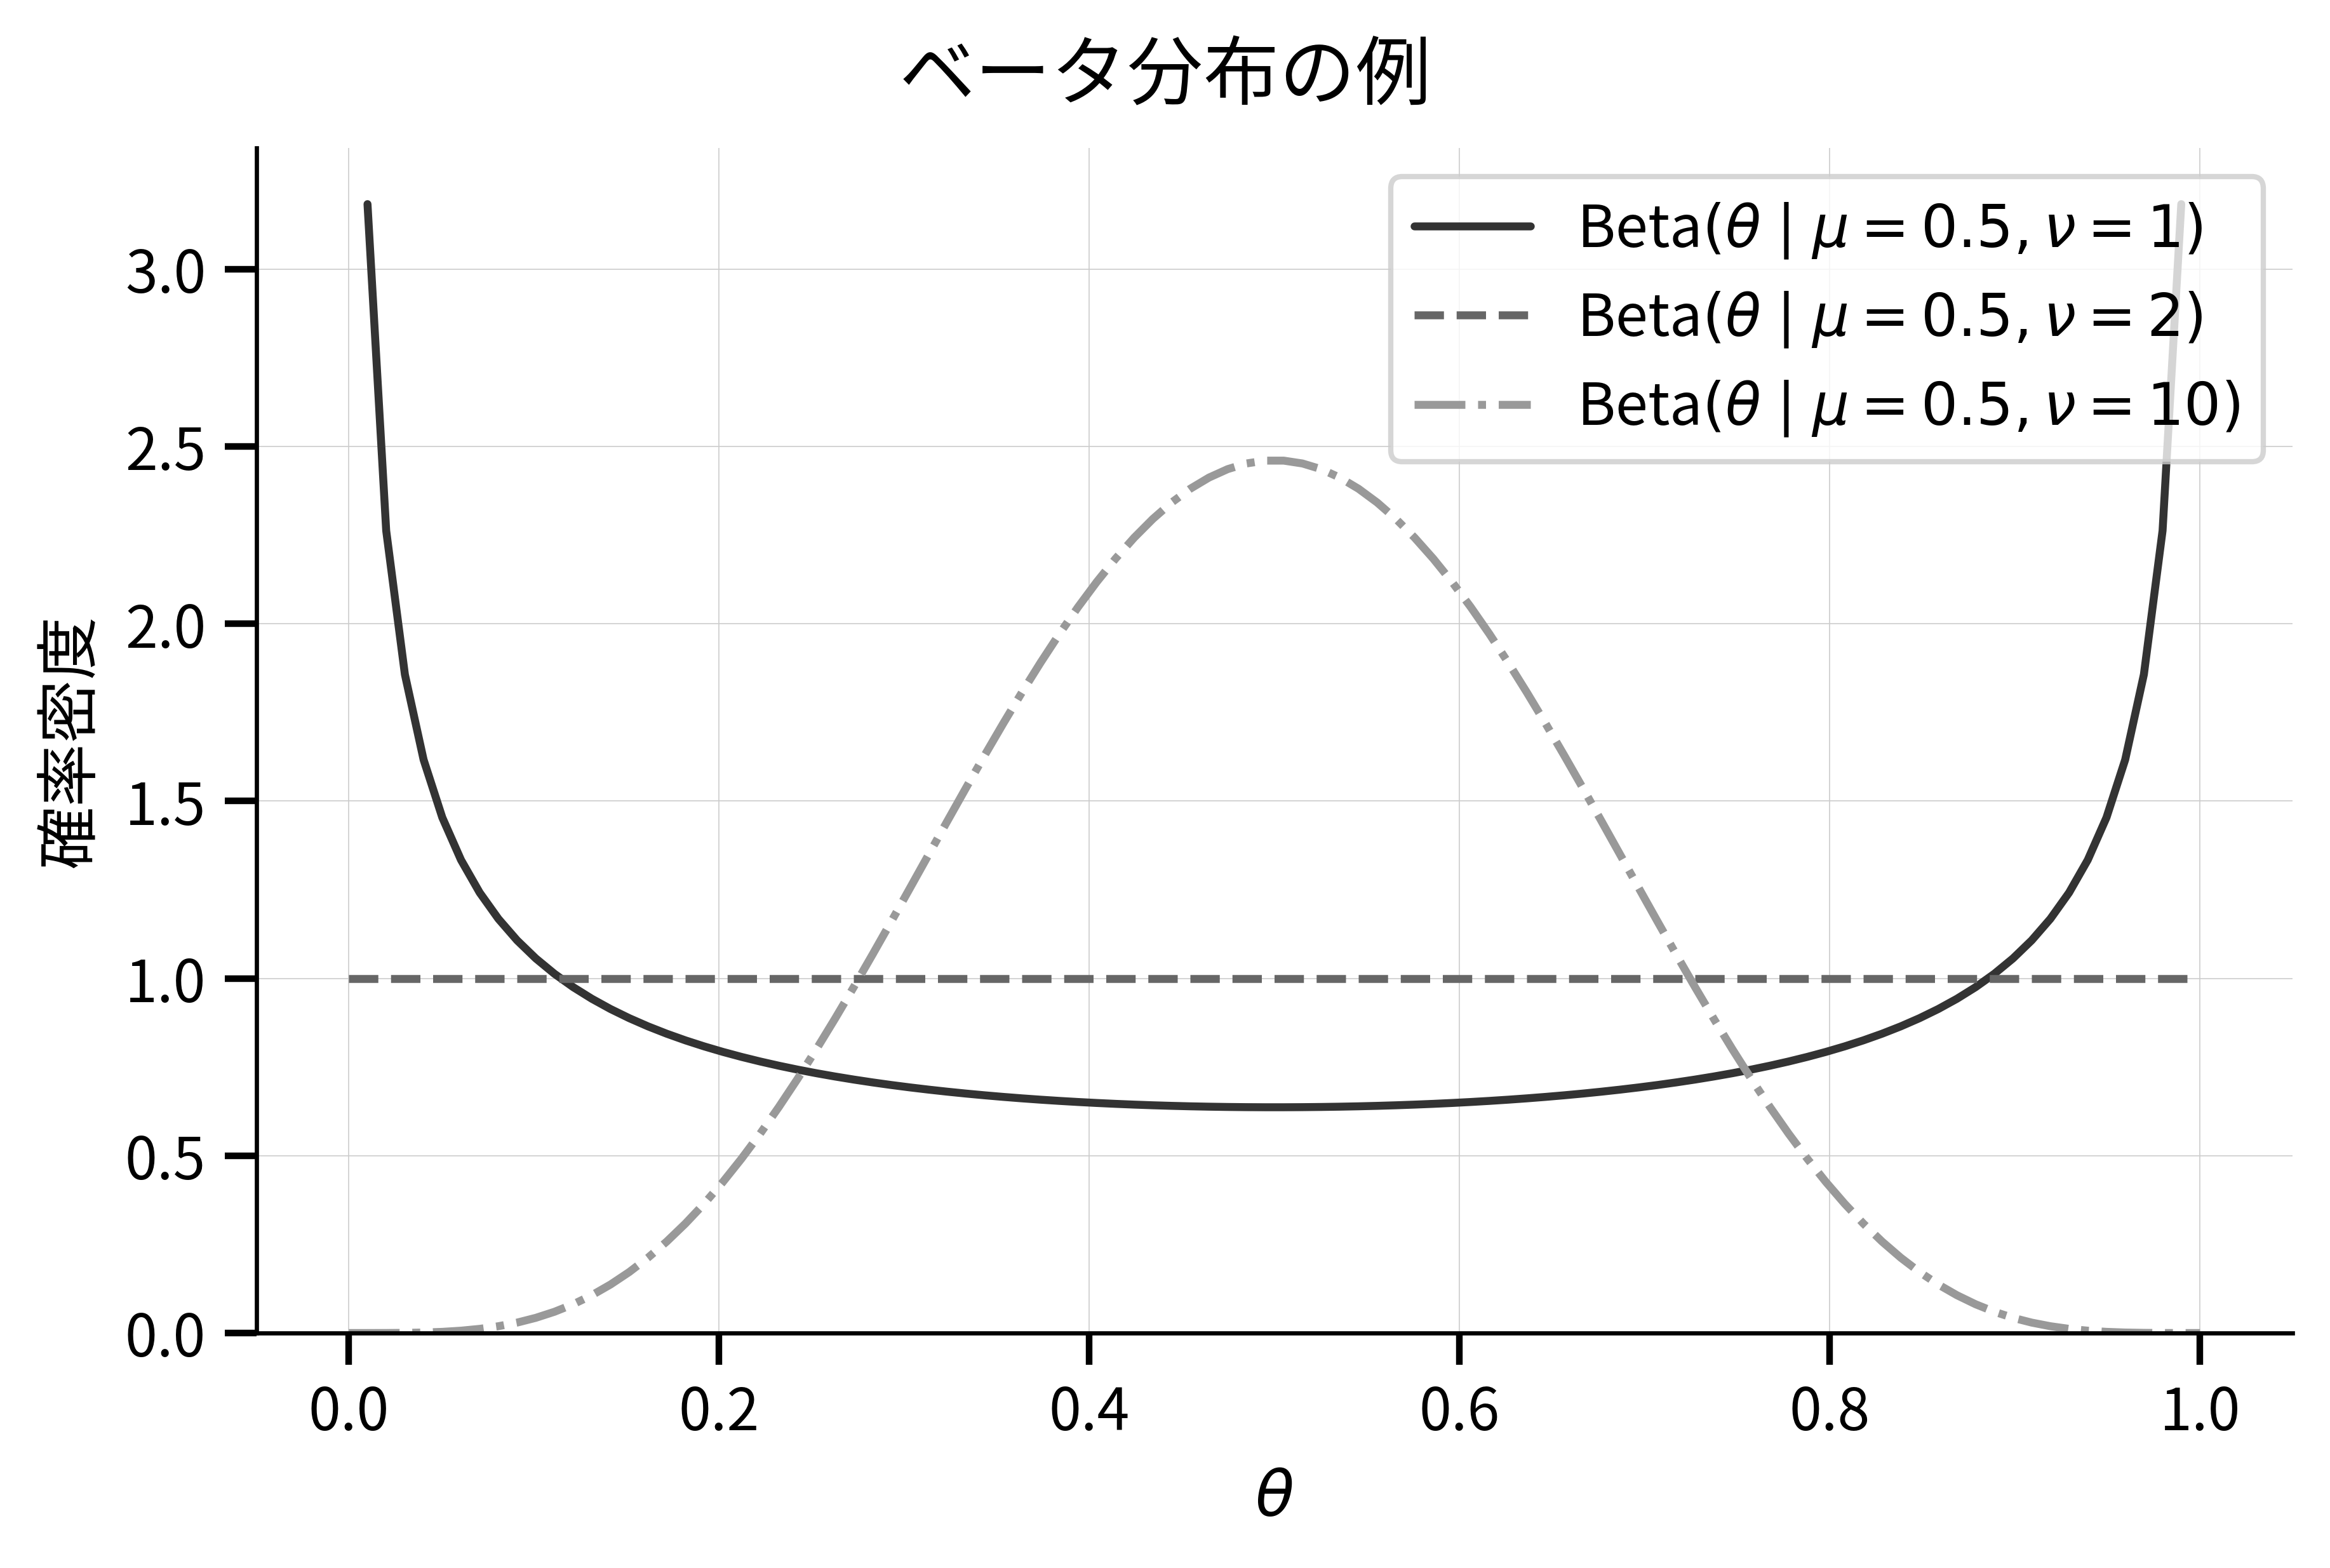

In [11]:
import scipy.stats


def plot_beta(
    theta: np.ndarray,
    mu_list: list[float],
    nu_list: list[float],
) -> tuple[Figure, Axes]:
    fig, ax = plt.subplots()

    linestyles = ["solid", "dashed", "dashdot", "dotted"]
    for i, (mu, nu) in enumerate(zip(mu_list, nu_list)):
        y = scipy.stats.beta.pdf(x=theta, a=mu * nu, b=(1 - mu) * nu)
        ax.plot(
            theta,
            y,
            linestyle=linestyles[i % len(linestyles)],
            label=f"Beta$(\\theta \\mid \\mu = {mu}, \\nu = {nu})$",
        )

    ax.legend()
    ax.set_ylim(0, None)
    ax.set_xlabel("$\\theta$")
    ax.set_ylabel("確率密度")
    fig.suptitle("ベータ分布の例")

    return fig, ax


fig, ax = plot_beta(
    theta=np.linspace(0, 1, 100),
    mu_list=[0.5, 0.5, 0.5],
    nu_list=[1, 2, 10],
)

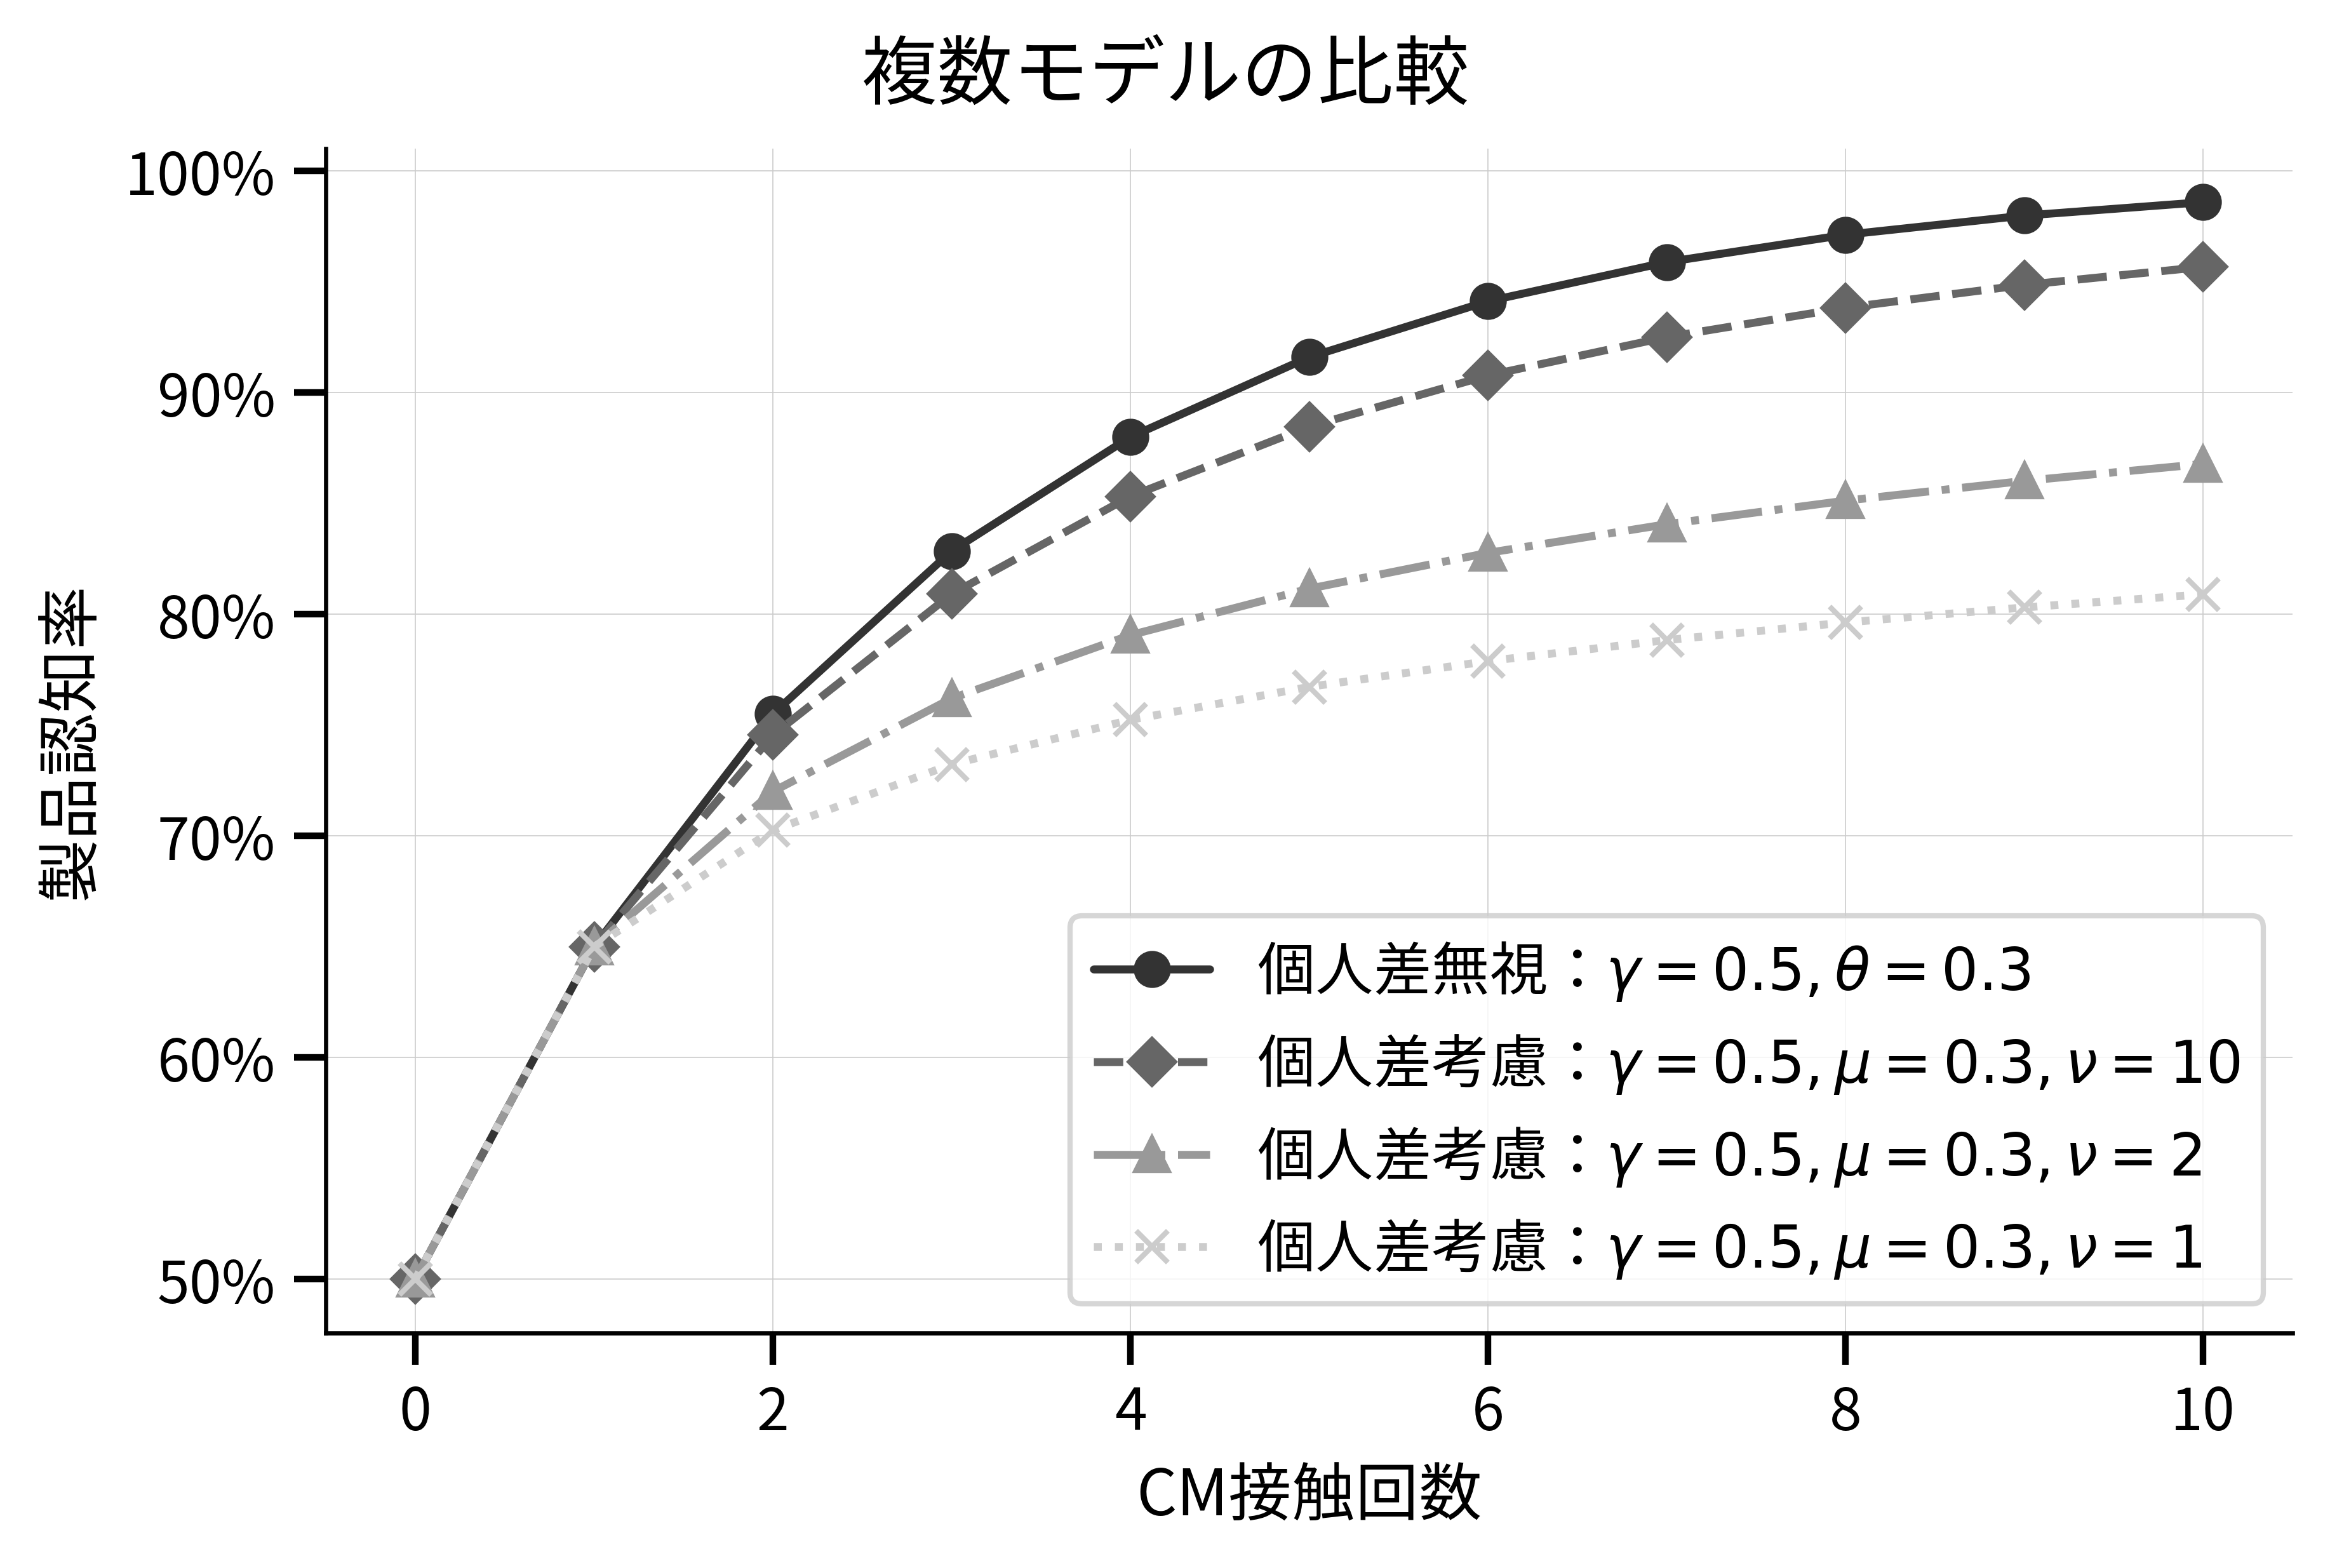

In [12]:
from scipy.special import beta


def plot_awareness_frequency_relations(
    f: np.ndarray,
    gamma: float,
    theta: float,
    mu_list: list[float],
    nu_list: list[float],
) -> tuple[Figure, Axes]:
    fig, ax = plt.subplots()

    # 個人差を考慮しない場合
    a = 1 - (1 - gamma) * (1 - theta) ** f
    ax.plot(
        f,
        a,
        label=f"個人差無視：$\\gamma = {gamma}, \\theta = {theta}$",
        marker="o",
        linestyle="solid",
        zorder=1,
    )

    # 個人差を考慮した場合
    markers = ["D", "^", "x"]
    linestyles = ["dashed", "dashdot", "dotted"]
    for i, (mu, nu) in enumerate(zip(mu_list, nu_list)):
        a = 1 - (1 - gamma) * beta(mu * nu, (1 - mu) * nu + f) / beta(
            mu * nu, (1 - mu) * nu
        )
        ax.plot(
            f,
            a,
            marker=markers[i % len(markers)],
            linestyle=linestyles[i % len(linestyles)],
            label=f"個人差考慮：$\\gamma = {gamma}, \\mu = {mu}, \\nu = {nu}$",
            zorder=2,
        )

    ax.legend()

    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
    ax.set(xlabel="CM接触回数", ylabel="製品認知率")
    fig.suptitle("複数モデルの比較")

    return fig, ax


fig, ax = plot_awareness_frequency_relations(
    f=f,
    gamma=0.5,
    theta=0.3,
    mu_list=[0.3, 0.3, 0.3],
    nu_list=[10, 2, 1],
)

In [13]:
from scipy.optimize import minimize_scalar  # 最適化
from scipy.stats import nbinom  # 負の二項分布
from sklearn.base import (
    BaseEstimator,
    RegressorMixin,
)  # 回帰モデルの基底クラス
from sklearn.metrics import mean_squared_error  # 二乗誤差


class FrequencyEstimator(RegressorMixin, BaseEstimator):
    """
    グロスリーチとユニークリーチからフリークエンシーの分布を推定するモデル
    """

    def __init__(self) -> None:
        pass

    @staticmethod
    def _predict(g: np.ndarray, alpha: float) -> np.ndarray:
        """負の二項分布を仮定したリーチカーブの予測

        Args:
            g (np.ndarray): グロスリーチ
            alpha (float): 負の二項分布のパラメータ

        Returns:
            np.ndarray: リーチの予測値
        """

        return 1 - nbinom.pmf(k=0, p=alpha / (g + alpha), n=alpha)

    def fit(self, X: np.ndarray, y: np.ndarray) -> Self:
        """グロスリーチとユニークリーチの関係を学習

        Args:
            X (np.ndarray): 説明変数。グロスリーチを想定
            y (np.ndarray): 目低変数。ユニークリーチを想定

        Returns:
            Self: 学習済みモデル
        """

        # 二乗誤差を最小化するalphaを推定して保存
        self.alpha_: float = minimize_scalar(
            fun=lambda alpha: mean_squared_error(
                y, self._predict(g=X, alpha=alpha)
            ),  # 最小化したい関数
            bounds=(0.01, 100),  # 推定範囲。alphaは0より大きい
        ).x

        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        """学習済みのパラメータを使ってユニークリーチを予測

        グロスリーチとユニークリーチの関係性を学習するモデルなので、
        predictメソッドはユニークリーチを返すようにしている。
        実際はpredict_frequencyメソッドを使ってフリークエンシーを予測する想定。

        Args:
            X (np.ndarray): 説明変数。グロスリーチを想定

        Returns:
            np.ndarray: ユニークリーチの予測値
        """

        return self._predict(g=X, alpha=self.alpha_)

    def predict_frequency(self, X: np.ndarray | float, f_max: int) -> np.ndarray:
        """学習済みのパラメータを使ってフリークエンシーを予測

        Args:
            X (np.ndarray | float): 説明変数。グロスリーチを想定
            f_max (int): 予測するフリークエンシーの最大値

        Returns:
            np.ndarray:
                フリークエンシーの分布の予測値。f_max + 1列のデータが返ることに注意
        """

        f = np.arange(f_max + 1)
        return nbinom.pmf(
            k=f,
            p=self.alpha_ / (X + self.alpha_),
            n=self.alpha_,
        )

In [14]:
# モデルの学習
fe = FrequencyEstimator().fit(g_train, r_train)

In [15]:
# フリークエンシー分布の予測値のshapeを確認
f_max = 15
fe.predict_frequency(g_train, f_max=15).shape

(2, 16)

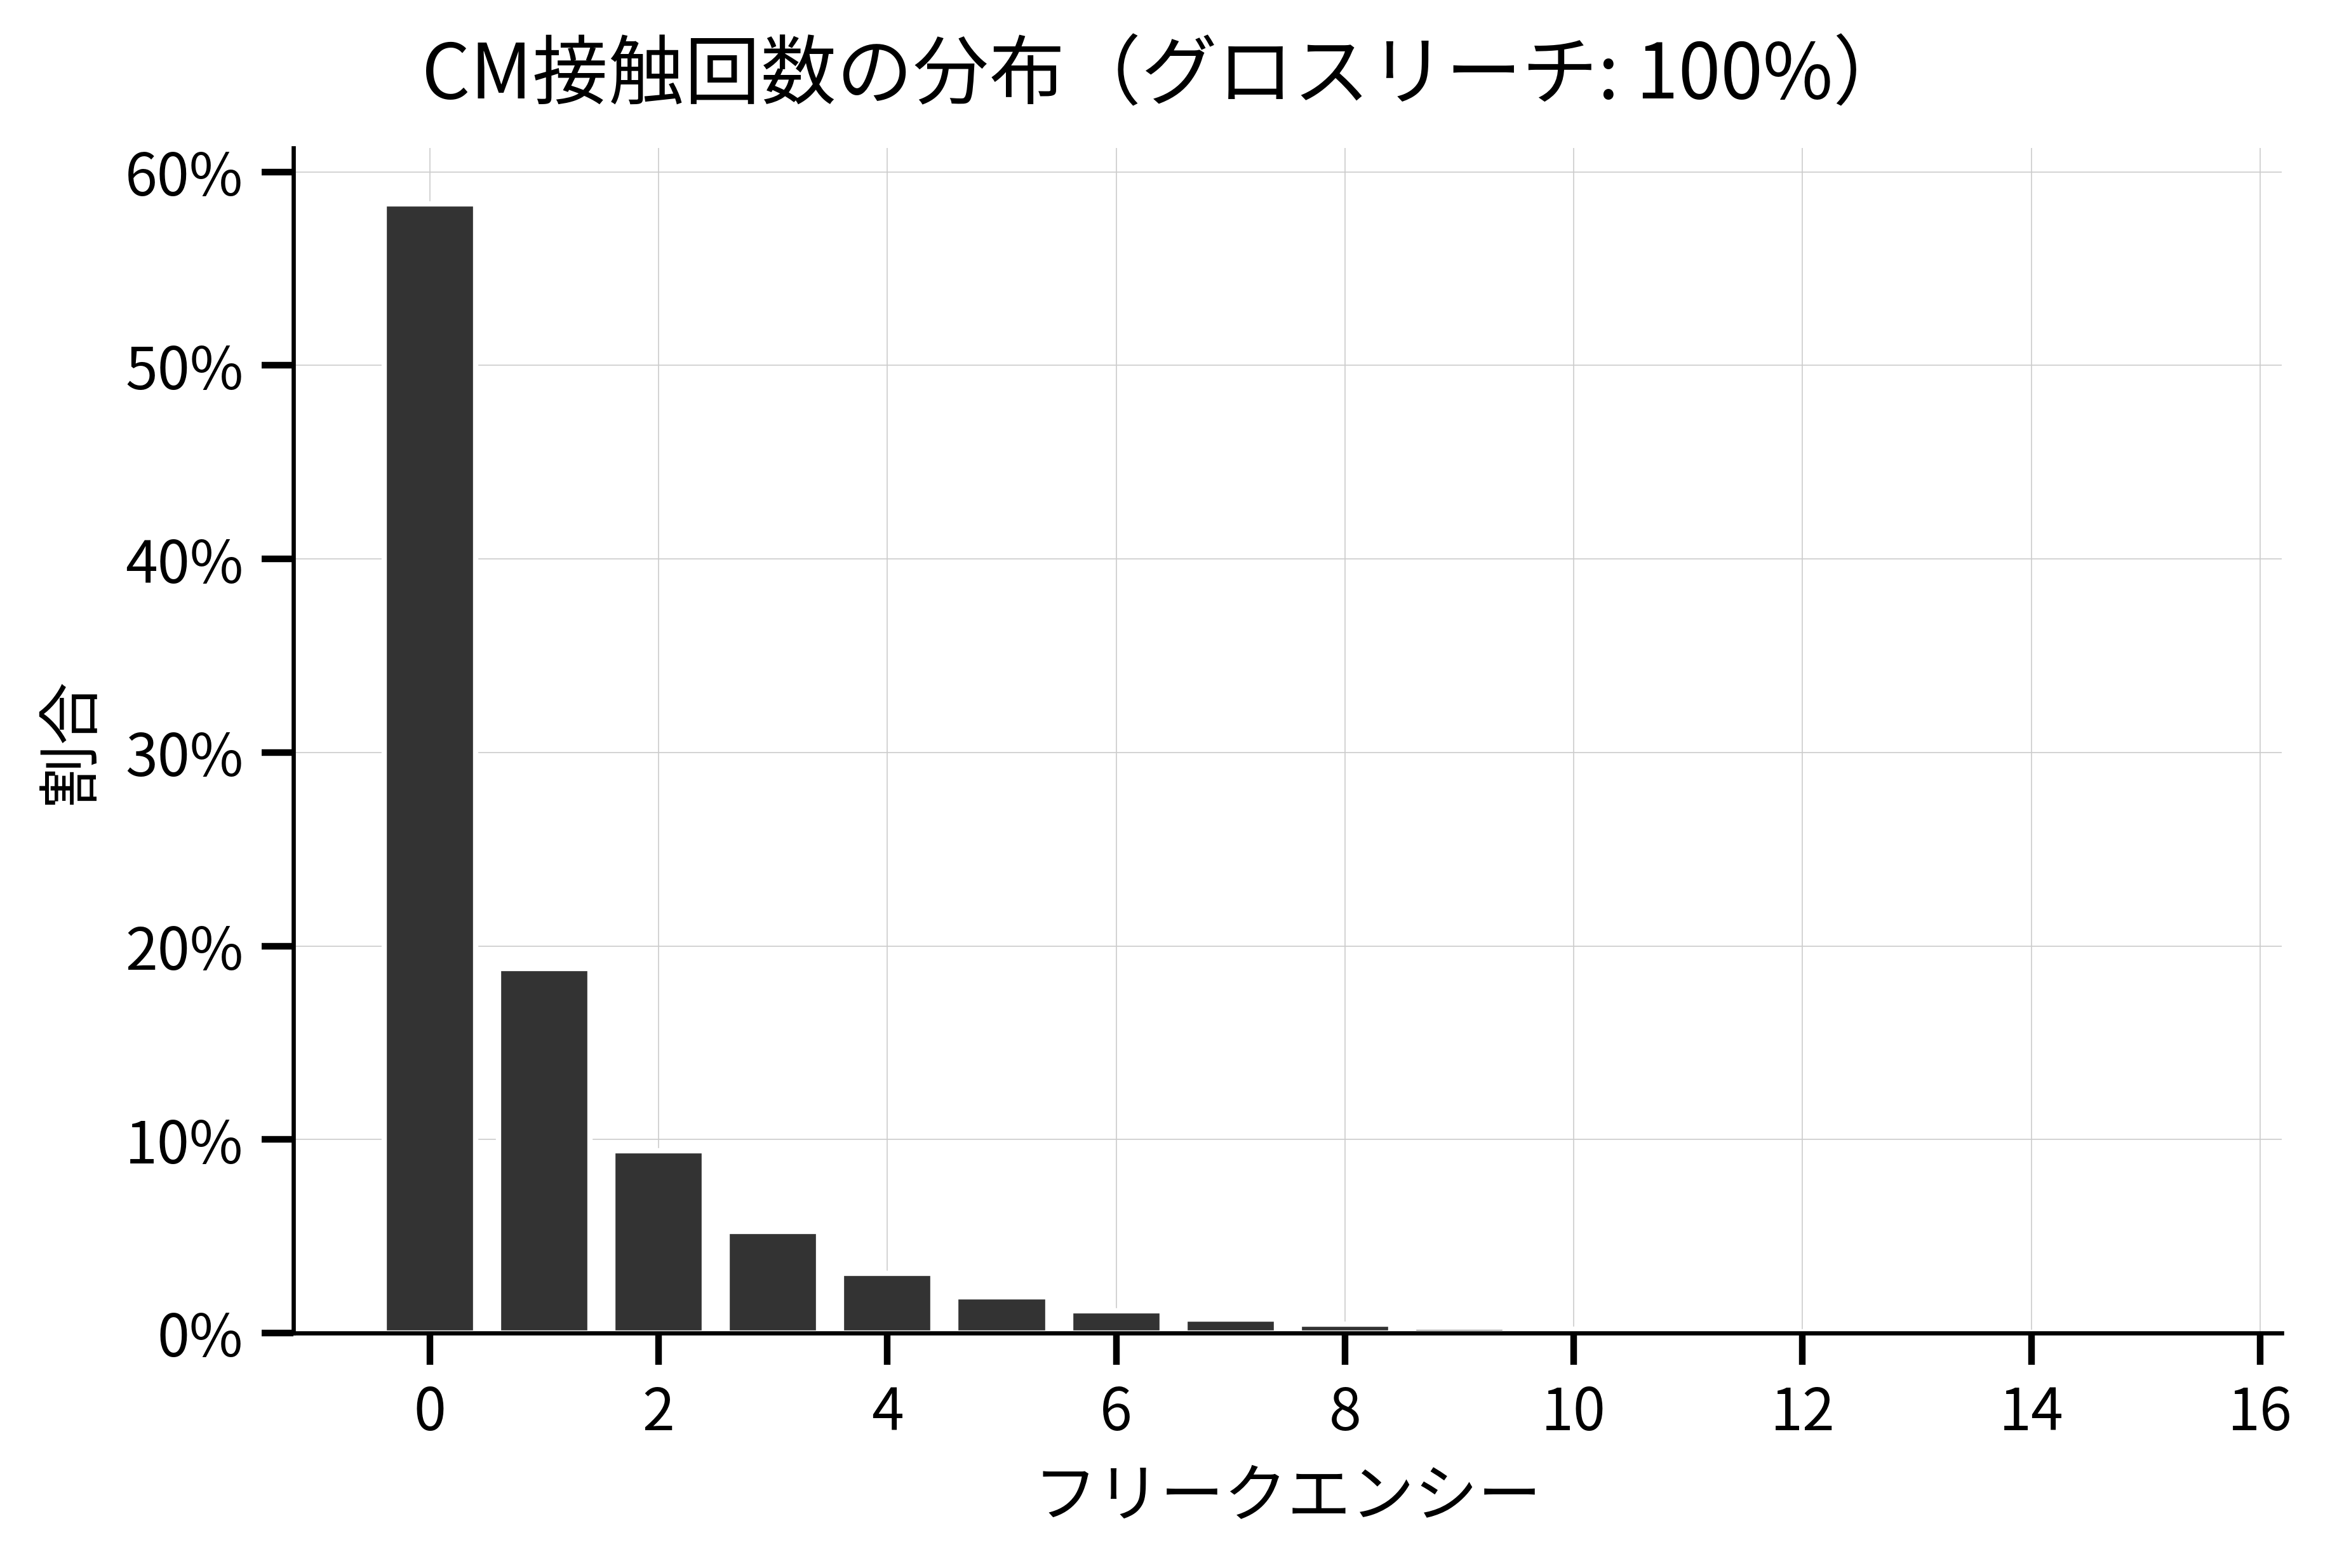

In [16]:
def plot_frequency_distribution(
    pr_f_given_g_pred: np.ndarray, f_max: int, title: str
) -> tuple[Figure, Axes]:
    """フリークエンシーの分布を可視化"""

    fig, ax = plt.subplots()
    ax.bar(np.arange(f_max + 1), pr_f_given_g_pred)
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
    ax.set(xlabel="フリークエンシー", ylabel="割合")
    fig.suptitle(title)

    return fig, ax


# グロスリーチが100%の場合を可視化
g = 1
fig, ax = plot_frequency_distribution(
    pr_f_given_g_pred=fe.predict_frequency(X=g, f_max=f_max),
    f_max=f_max,
    title=f"CM接触回数の分布（グロスリーチ: {g:.0%}）",
)

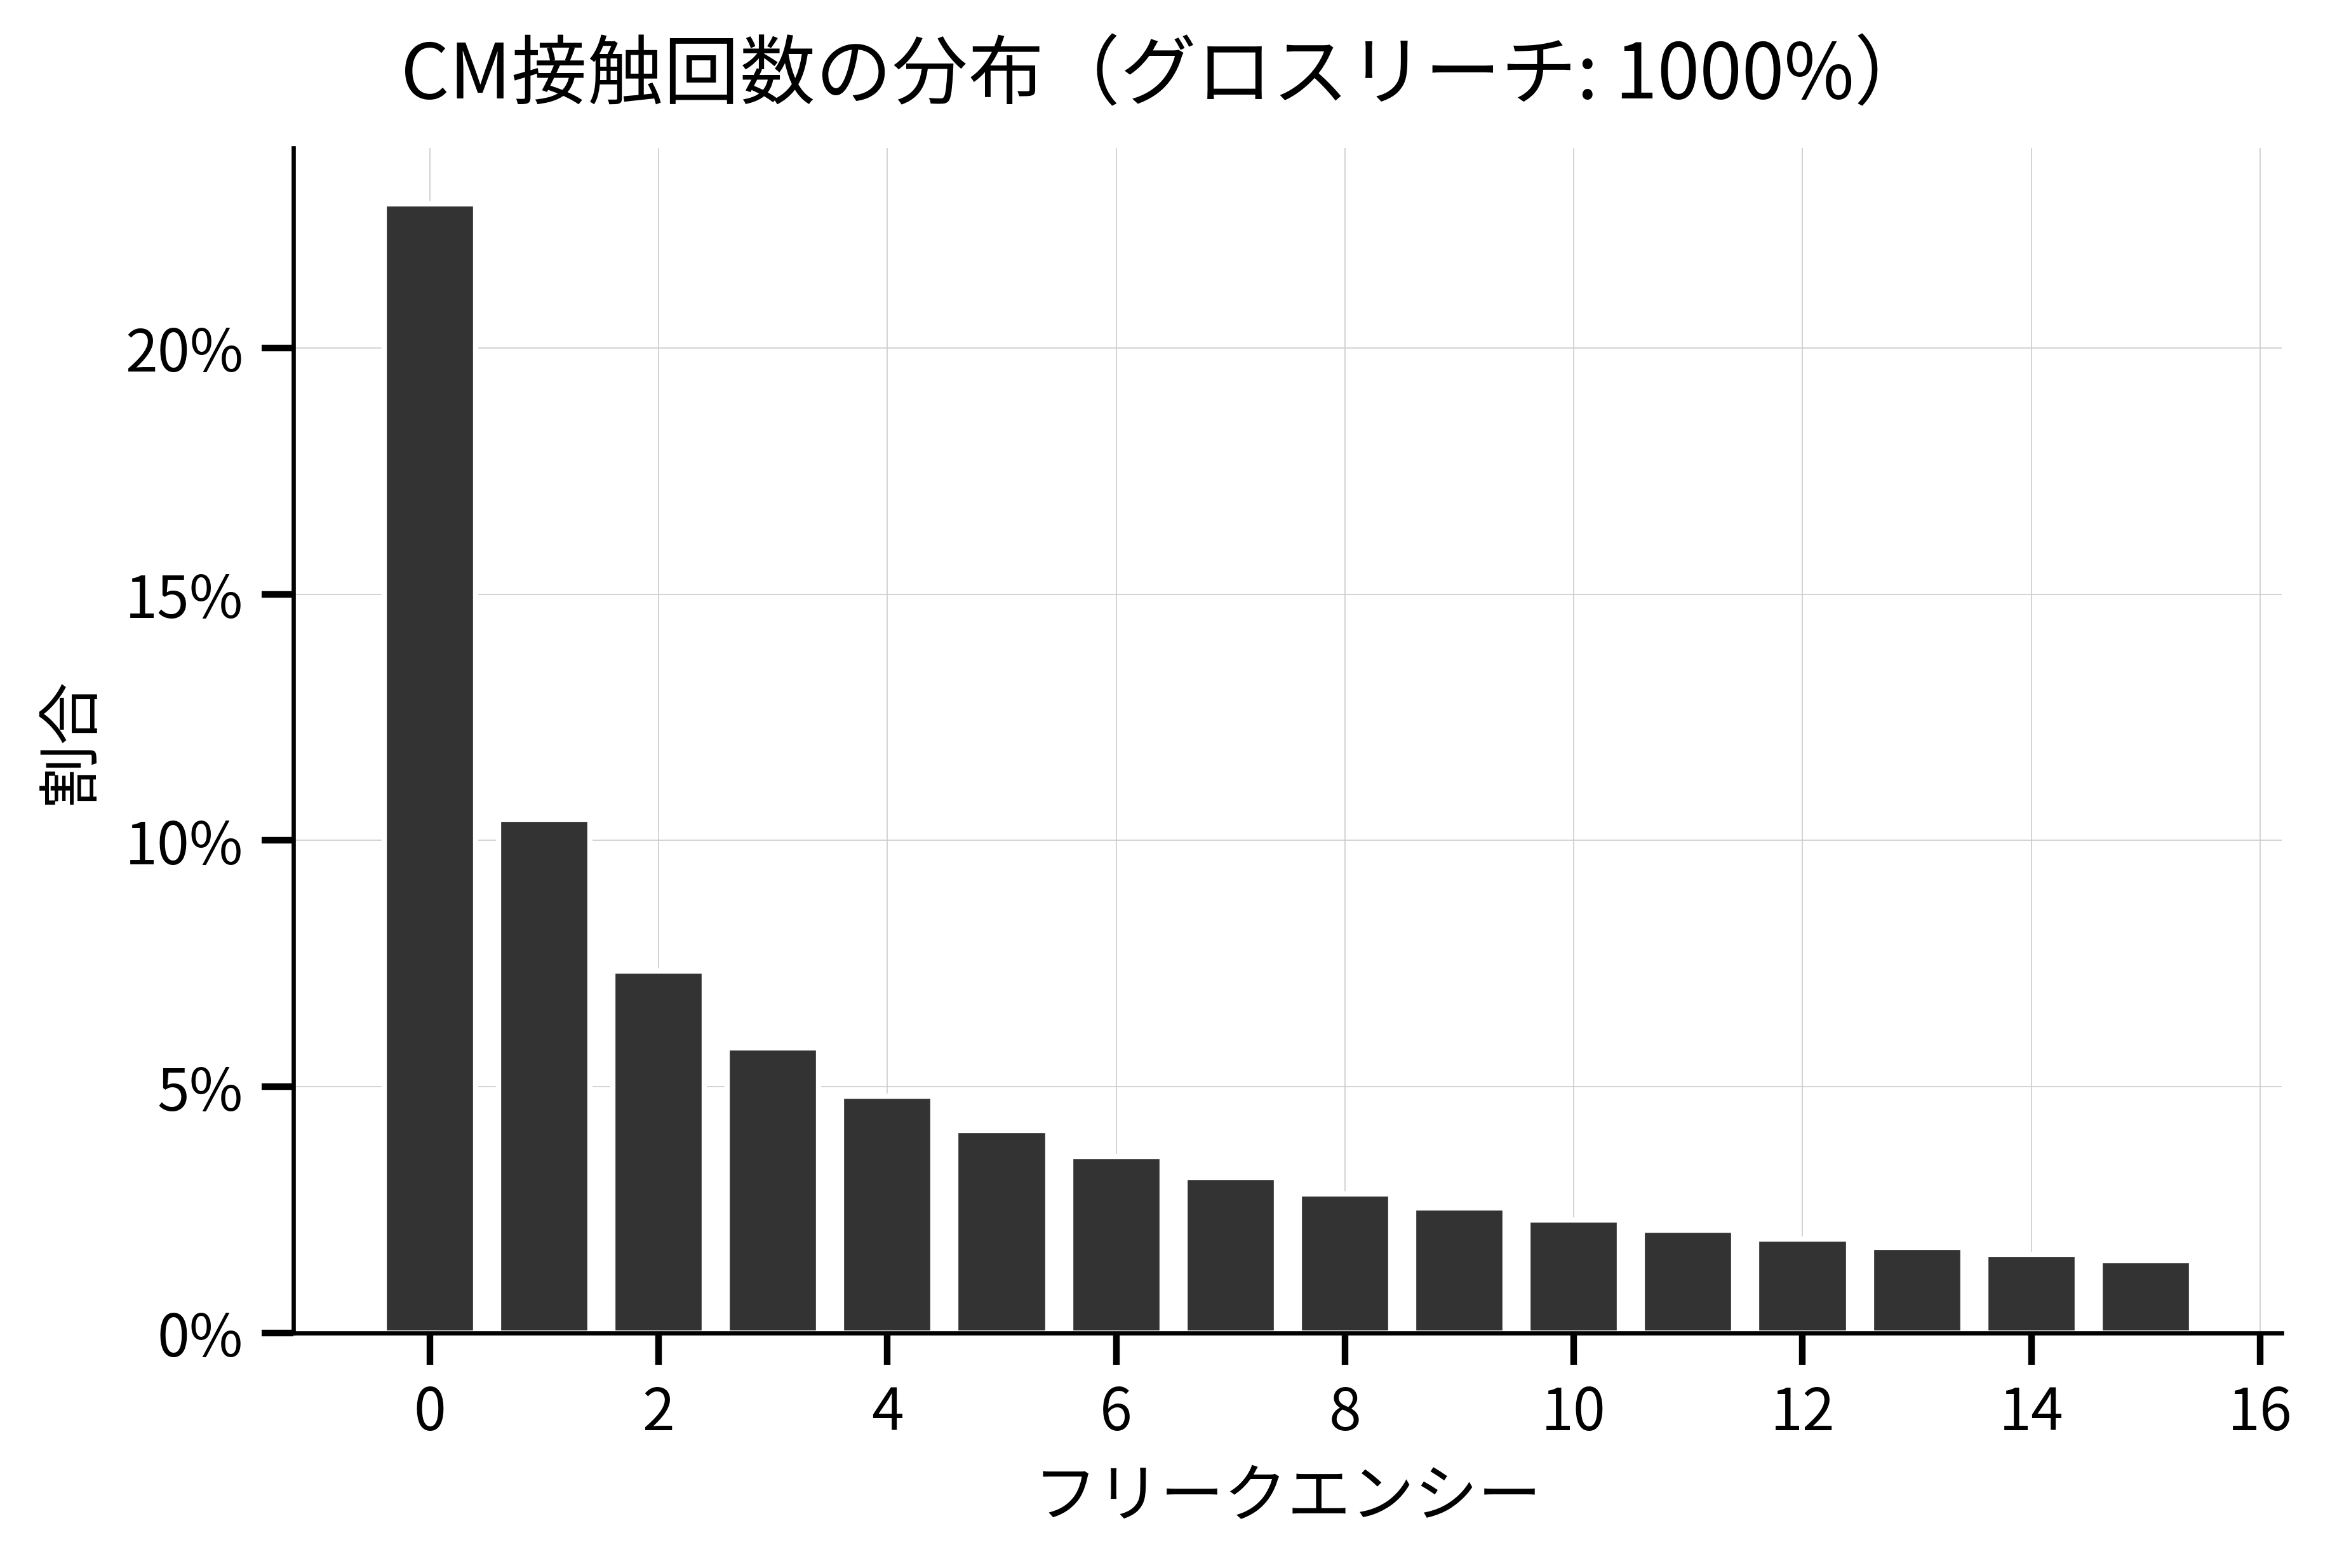

In [17]:
# グロスリーチが1000%の場合を可視化
g = 10
fig, ax = plot_frequency_distribution(
    pr_f_given_g_pred=fe.predict_frequency(X=g, f_max=f_max),
    f_max=f_max,
    title=f"CM接触回数の分布（グロスリーチ: {g:.0%}）",
)

NumPy 2.0以降は型ヒントの`np.float_`が削除されているので、`np.float64`に変更してください

In [ ]:
from scipy.optimize import minimize


class AwarenessCurveEstimator(RegressorMixin, BaseEstimator):
    """認知カーブを推定するモデル"""

    def __init__(
        self,
        frequency_estimator: FrequencyEstimator,
        f_max: int,
    ) -> None:
        """
        Args:
            frequency_estimator (FrequencyEstimator):
                学習済みのフリークエンシー分布の推定モデル
            f_max (int):
                モデルの学習と予測に利用するフリークエンシーの最大値
                f_max + 1回接触の発生確率がほぼ0になるくらい大きな値を設定する必要がある
                大きくしすぎると計算時間がかかるので必要十分な大きさにする。200程度が目安
        """

        self.frequency_estimator = frequency_estimator
        self.f_max = f_max

    @staticmethod
    def _calc_pr_a_given_f(
        f_max: int, gamma: float, mu: float, nu: float
    ) -> np.ndarray:
        """CM接触回数に対する製品認知率を予測

        Args:
            f_max (int): 何回接触までを出力するか
            gamma (float): 製品をそもそも知っている割合
            mu (float): CMに1回接触したときの製品認知率の期待値
            nu (float): CMに1回接触したときの製品認知率の密集度

        Returns:
            np.ndarray: 製品認知率
        """

        f = np.arange(f_max + 1)
        return 1 - (1 - gamma) * beta(mu * nu, (1 - mu) * nu + f) / beta(
            mu * nu, (1 - mu) * nu
        )

    def _predict(self, X: np.ndarray, gamma: float, mu: float, nu: float) -> np.ndarray:
        """グロスリーチに対する製品認知率を計算

        Args:
            X (np.ndarray): 説明変数。グロスリーチを想定
            gamma (float): 製品をそもそも知っている割合
            mu (float): CMに1回接触したときの製品認知率の期待値
            nu (float): CMに1回接触したときの製品認知率の密集度

        Returns:
            np.ndarray: 製品認知率
        """

        # グロスリーチに対するCM接触回数の分布を予測
        pr_f_given_g = self.frequency_estimator.predict_frequency(X, self.f_max)

        # CM接触回数ごとの製品認知率を予測
        pr_a_given_f = self._calc_pr_a_given_f(self.f_max, gamma, mu, nu)

        # ふたつを合わせてグロスリーチに対する製品認知率を計算
        return pr_a_given_f @ pr_f_given_g.T

    def _negative_log_likelihood(
        self,
        params: np.ndarray,
        X: np.ndarray,
        y: np.ndarray,
    ) -> np.float_:
        """最小化したい負の対数尤度

        Args:
            params (np.ndarray): 推定するパラメータ。gamma, mu, nuの順
            X (np.ndarray): 説明変数。グロスリーチを想定
            y (np.ndarray): 目的変数。製品認知率を想定

        Returns:
            np.float_: 負の対数尤度
        """

        # グロスリーチから製品認知率を予測
        gamma, mu, nu = params
        pr_a_given_g = self._predict(X, gamma, mu, nu)

        # minimize関数は最小化なので、大雄遊度でなく負の対数尤度を返す
        return -np.mean(y * np.log(pr_a_given_g) + (1 - y) * np.log(1 - pr_a_given_g))

    def fit(self, X: np.ndarray, y: np.ndarray) -> Self:
        """モデルの学習

        Args:
            X (np.ndarray): 説明変数。グロスリーチを想定
            y (np.ndarray): 目的変数。認知率を想定

        Returns:
            Self: 学習済みモデル
        """

        result = minimize(
            fun=lambda params: self._negative_log_likelihood(params=params, X=X, y=y),
            x0=np.array([0.5, 0.5, 1]),  # 初期値
            bounds=[
                (0.01, 0.99),
                (0.01, 0.99),
                (0.01, 10),
            ],  # 推定範囲
            tol=1e-10,  # 収束判定
        )

        # 学習したパラメータを保存
        self.gamma_, self.mu_, self.nu_ = result.x

        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        """学習済みのパラメータを使ってグロスリーチに対する製品認知率を予測

        Args:
            X (np.ndarray): 説明変数。グロスリーチを想定

        Returns:
            np.ndarray: 製品認知率の予測値
        """

        return self._predict(X, self.gamma_, self.mu_, self.nu_)

    def predict_frequency_awareness_relation(self, f_max: int) -> np.ndarray:
        """学習済みのパラメータを使ってCM接触回数に対する製品認知率を予測

        Args:
            f_max (int): 何回接触までを出力するか

        Returns:
            np.ndarray: 製品認知率の予測値
        """

        return self._calc_pr_a_given_f(f_max, self.gamma_, self.mu_, self.nu_)

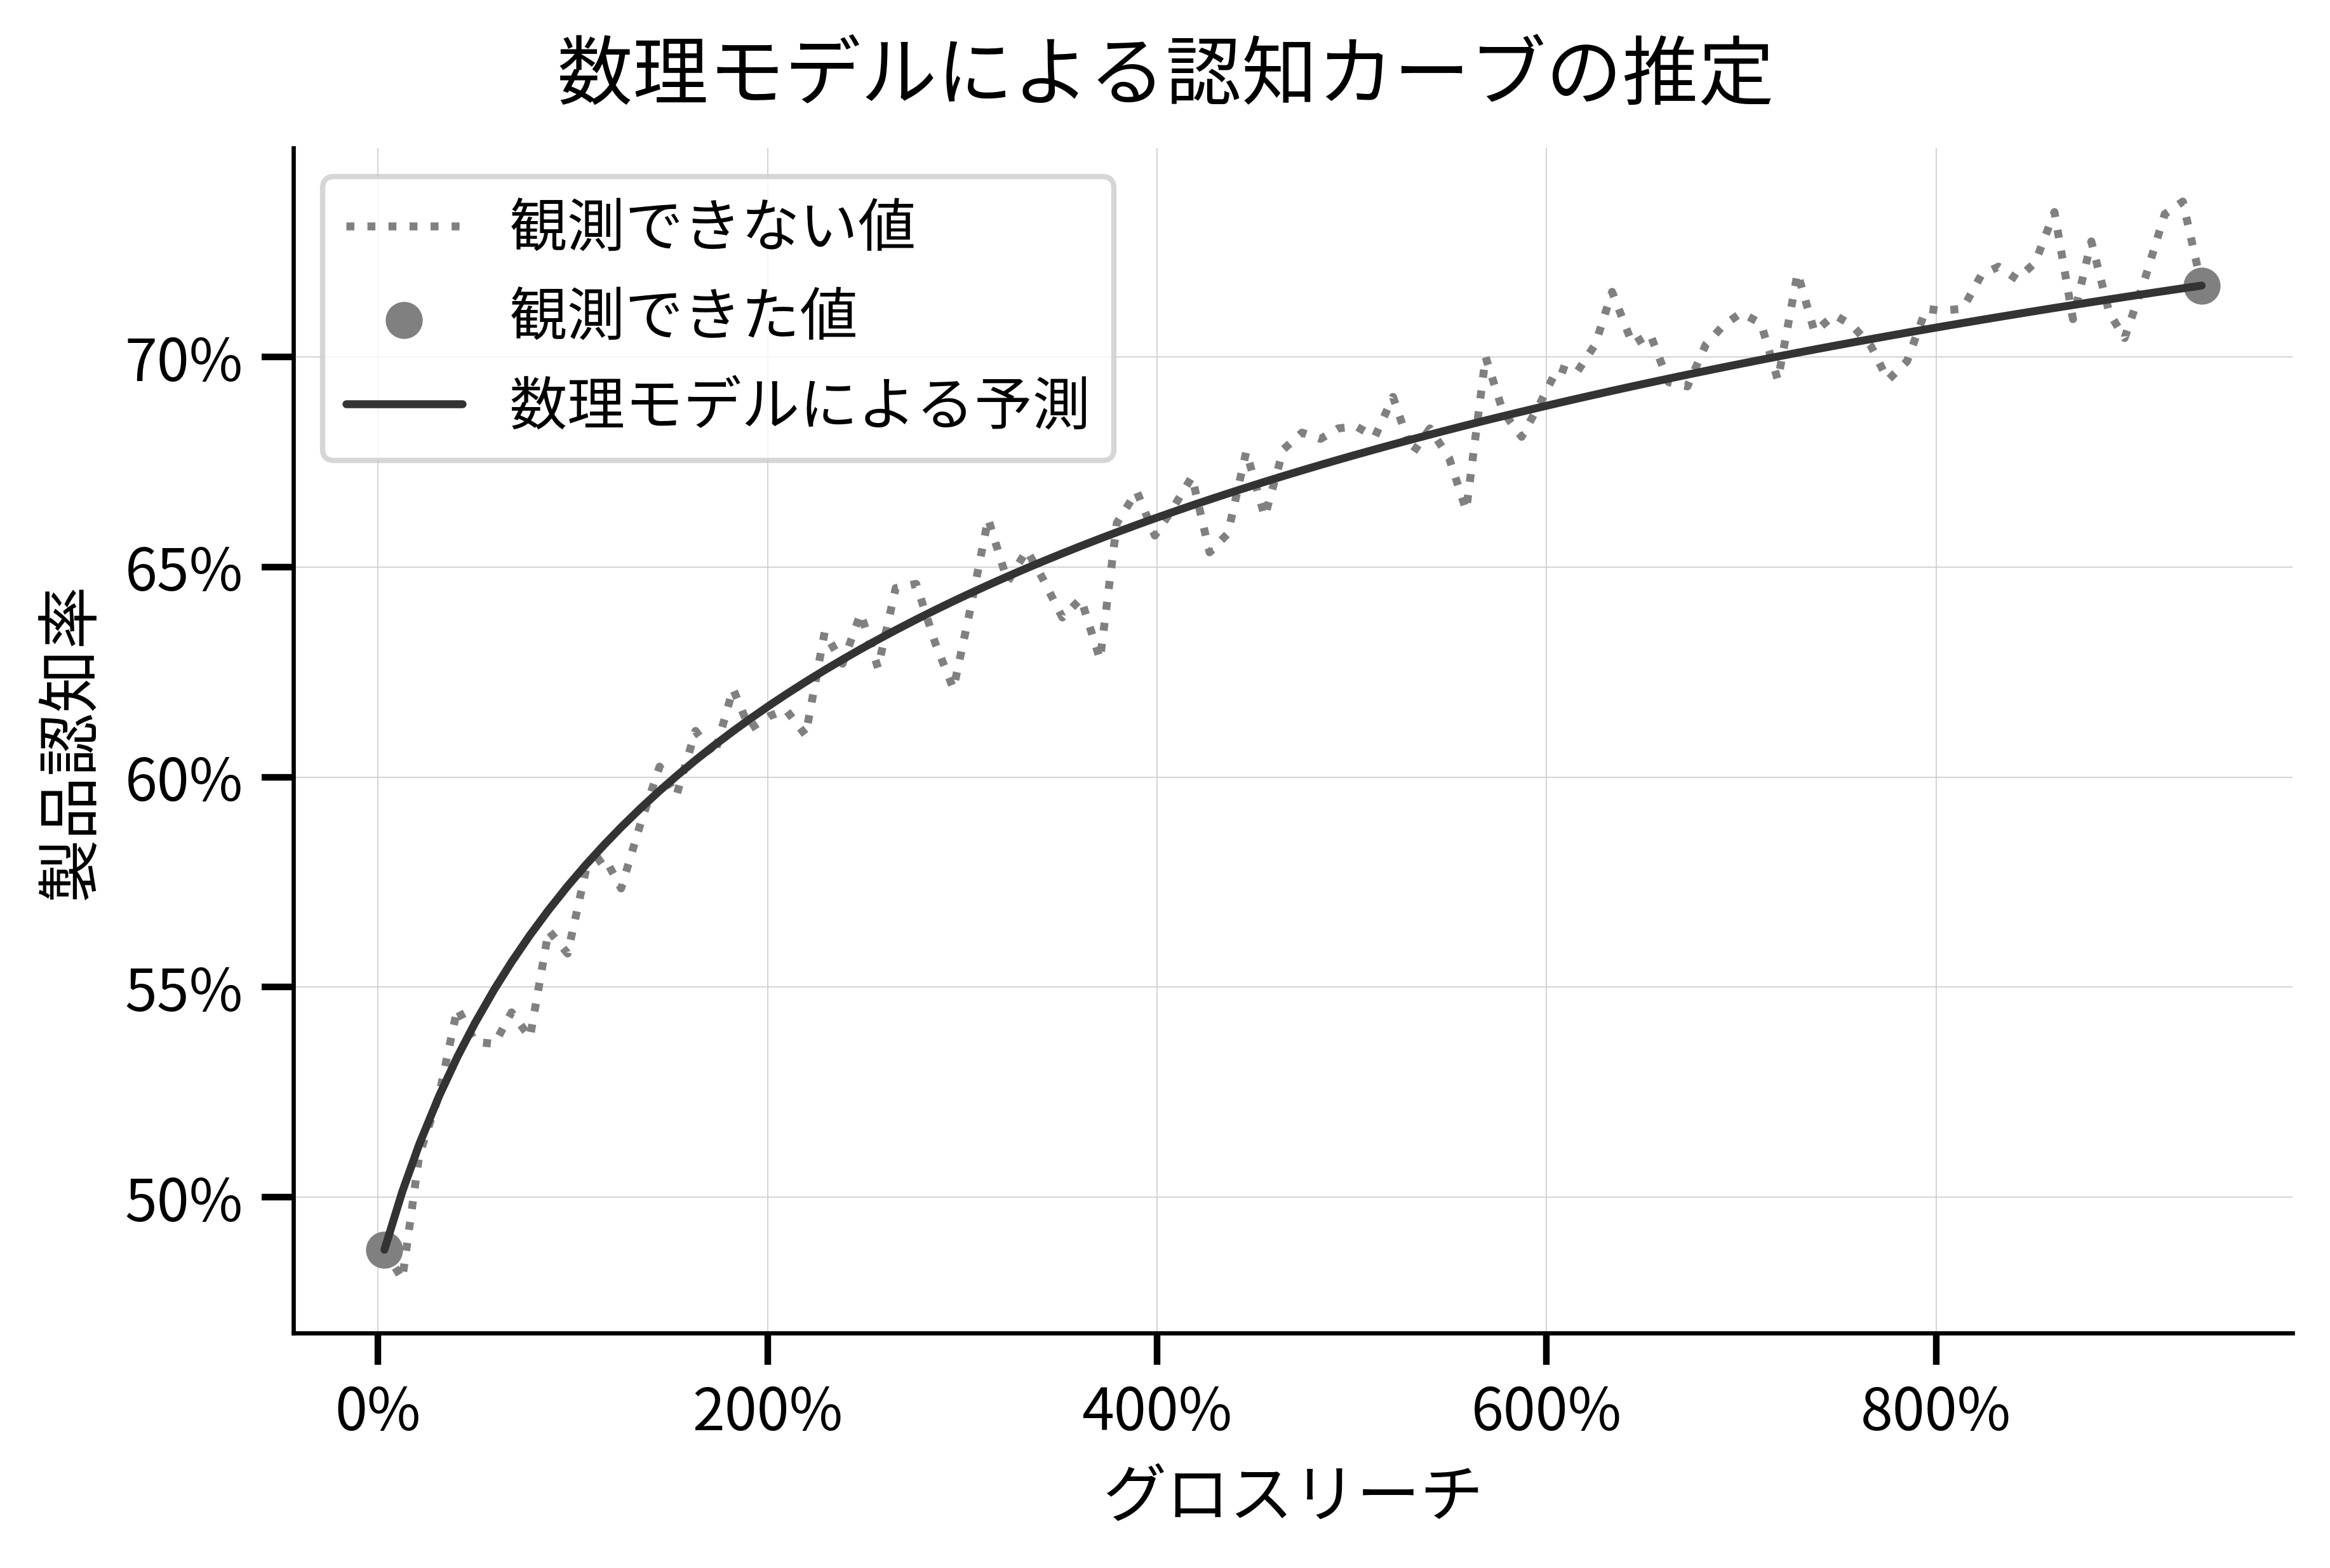

In [19]:
# モデルの学習
ace = AwarenessCurveEstimator(frequency_estimator=fe, f_max=200)
ace.fit(X=g_train, y=a_train)

# 認知カーブの推定
a_pred_ace = ace.predict(X=g_test)

# 認知カーブの可視化
fig, ax = plot_awareness_with_prediction(
    df_awareness=df_awareness,
    df_awareness_observed=df_awareness_observed,
    a_pred=a_pred_ace,
    prediction_label="数理モデルによる予測",
    title="数理モデルによる認知カーブの推定",
)

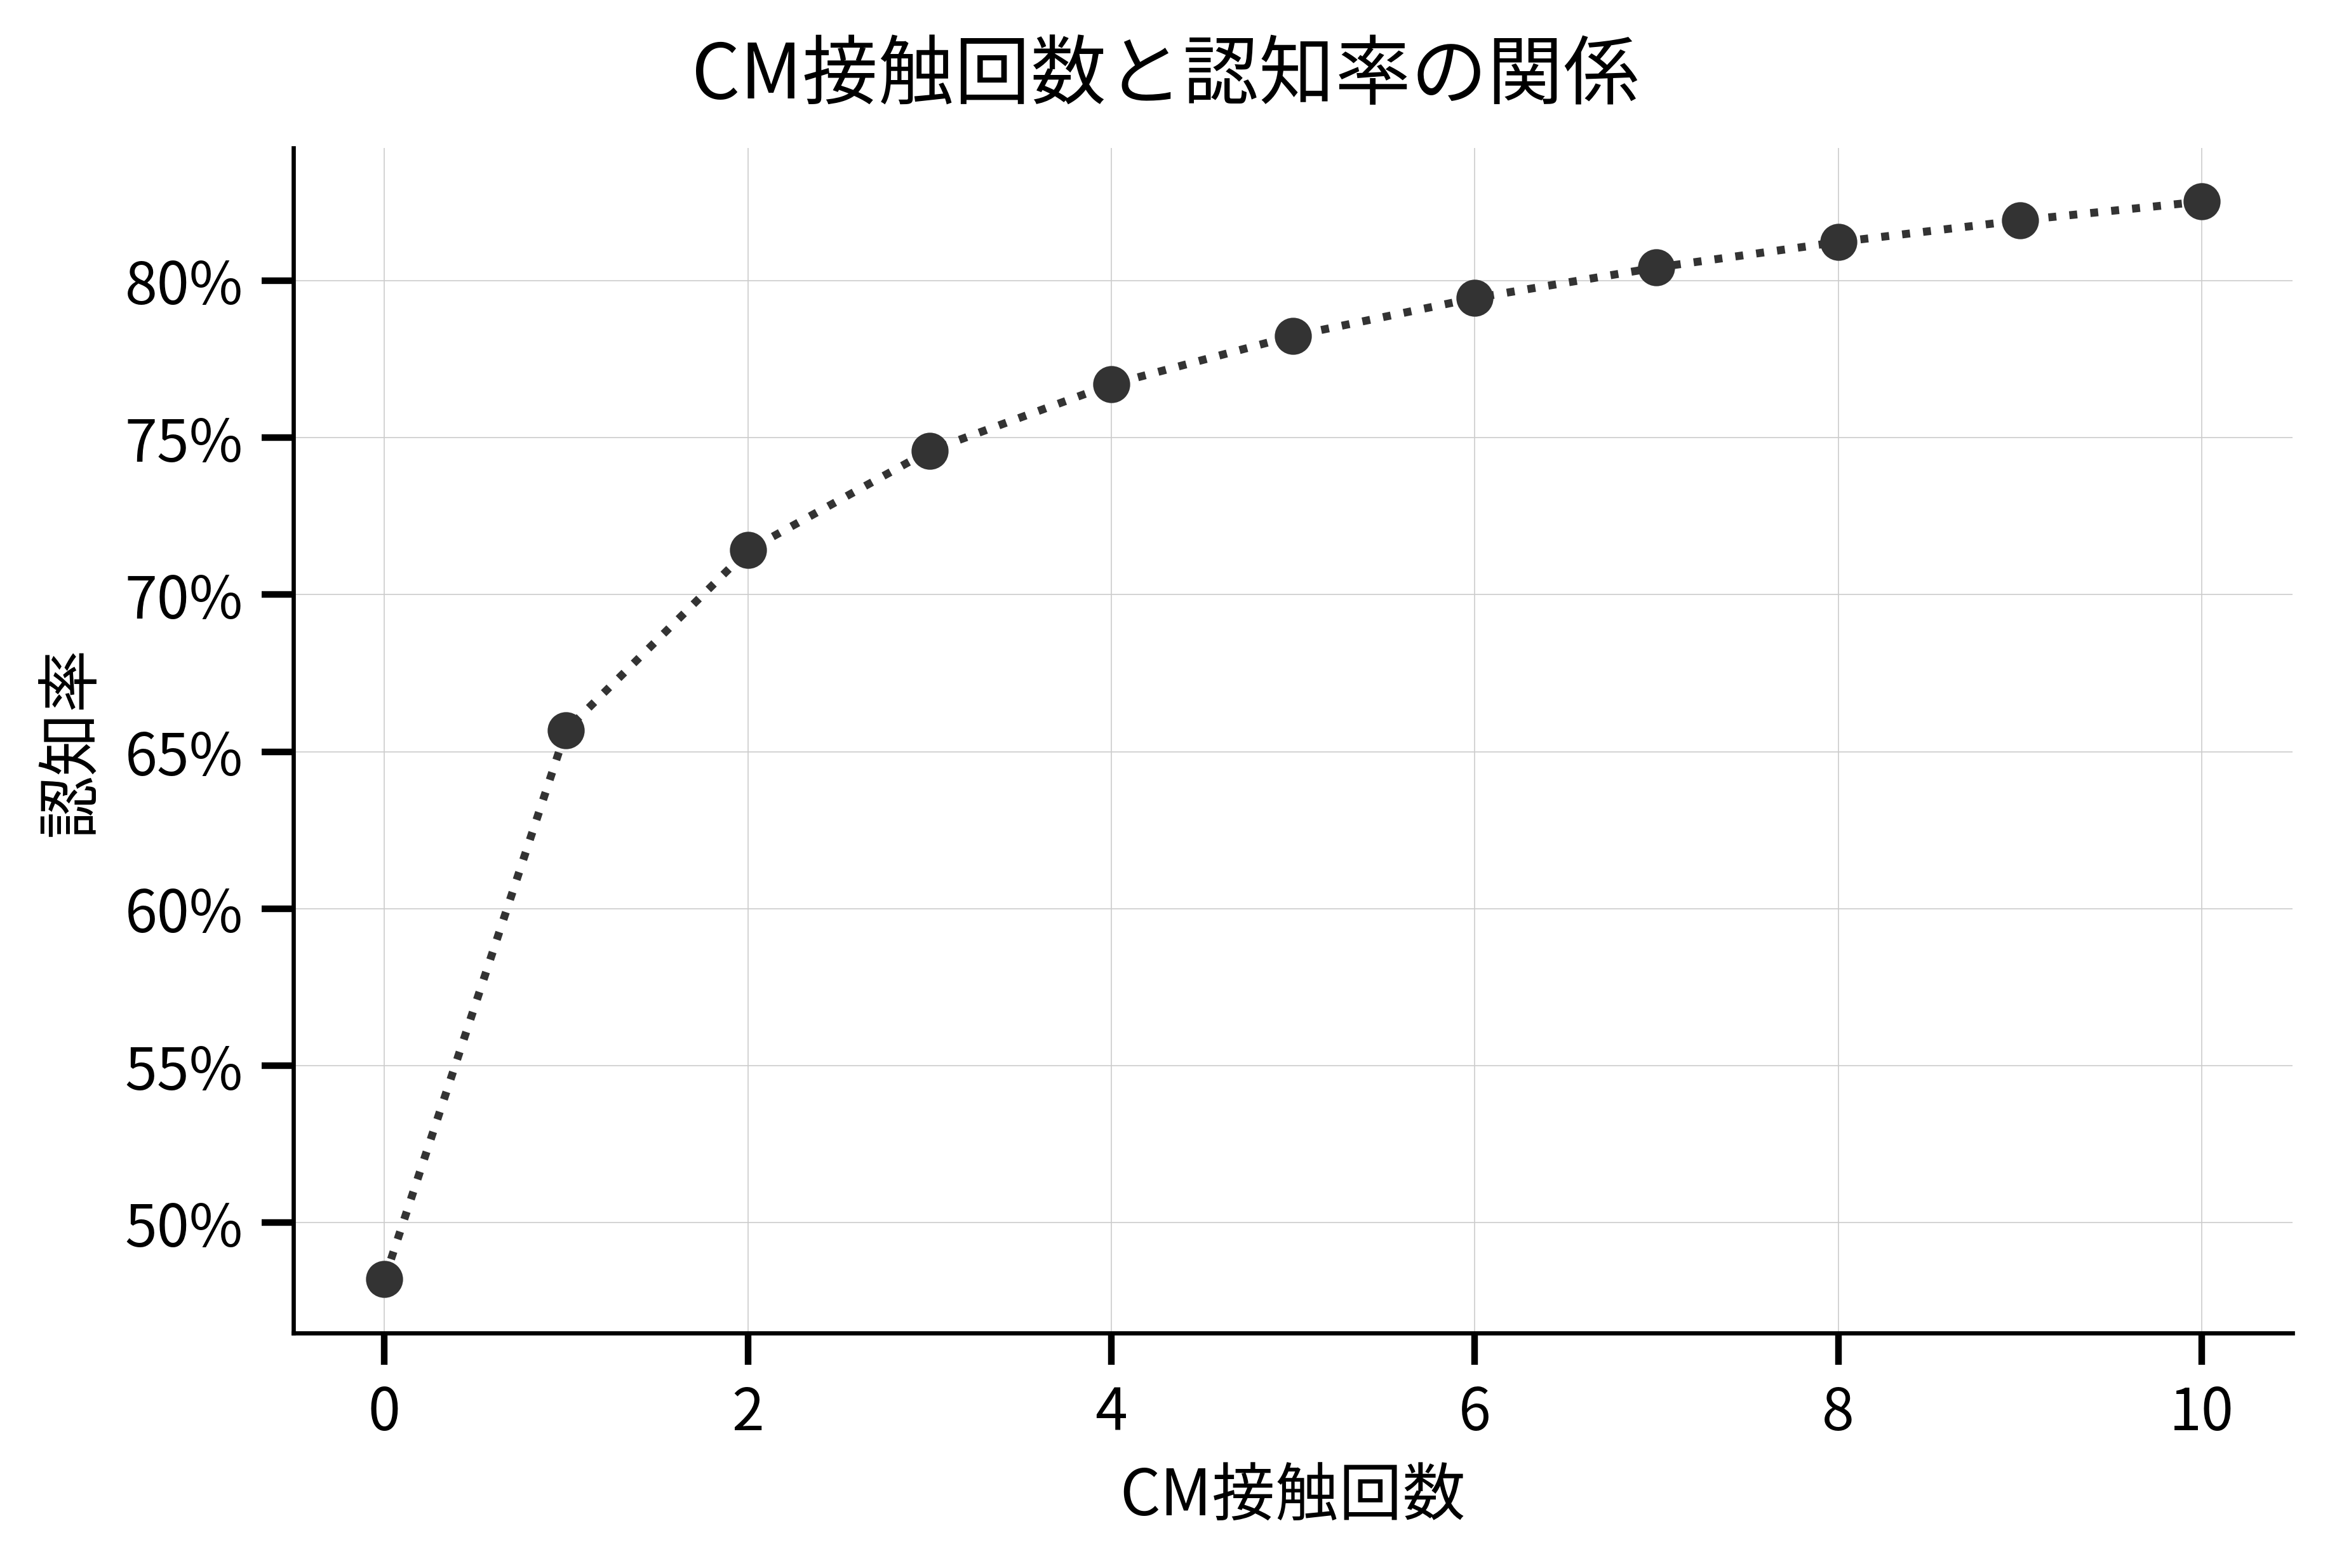

In [20]:
f_max = 10
f = np.arange(f_max + 1)
pr_a_given_f_pred = ace.predict_frequency_awareness_relation(f_max=f_max)

# 可視化
fig, ax = plot_awareness_frequency_relation(f, a_pred=pr_a_given_f_pred)

In [21]:
print(f"gamma: {ace.gamma_: .2f}")
print(f"mu: {ace.mu_: .2f}")
print(f"nu: {ace.nu_: .2f}")

gamma:  0.48
mu:  0.34
nu:  0.98


## ステップ3：数理最適化問題を解いて 最適なアクションを導出する

In [22]:
c = 10  # グロスリーチ1%あたりのコスト（万円単位）
b = 10000  # 予算上限（万円単位）
a_lb = 0.65  # 製品認知率の目標値

# 制約条件のもとで費用を最小化
result = minimize(
    fun=lambda g: 100 * c * g,
    x0=1,
    bounds=[(0, None)],
    constraints=[
        # 予算制約
        {"type": "ineq", "fun": lambda g: b - 100 * c * g},
        # 目標を達成する制約
        {
            "type": "ineq",
            "fun": lambda g: ace.predict(np.array([g])) - a_lb,
        },
    ],
)

print(f"目標を達成するには{result.x[0]:.0%}のグロスリーチが必要")
print(f"その場合の費用は{result.fun:.0f}万円")

目標を達成するには334%のグロスリーチが必要
その場合の費用は3344万円


## まとめ